<a href="https://colab.research.google.com/github/AlexNoonan-Syracuse/BigDataProject/blob/main/Final_Submission_VF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Final Project Submission
IST_718
Alex Noonan
Matt Sartalis
Renato Cruzalegui
Shannon Whitlock

In [ ]:
!pip install quandl

# Reading in the Data
Reading in the Economic Data from Mulitple Sources


1.   CSV of data from St. Louis Fed 
2.   Request from Quandl API
3.   Web Scrape from US Treasury Website


In [ ]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import grangercausalitytests as grangercausalitytests
import quandl
import requests
from bs4 import BeautifulSoup
import numpy as np





# reading in macro datacsv
df1 = pd.read_csv("https://raw.githubusercontent.com/AlexNoonan-Syracuse/BigDataProject/main/Macro%20Data.csv")

df1['DATE'] = df1['DATE'].apply(lambda x: datetime.datetime.strptime(str(x), "%m/%d/%Y"))
#df1.drop(columns=["Unnamed: 7", "% Change (M/M)", "%Change (Q/Q)", "% Change (Y/Y)", "% Change Q/Q", "DATE"], inplace =True )
df1['Year'] = pd.DatetimeIndex(df1['DATE']).year
df1['Month'] = pd.DatetimeIndex(df1['DATE']).month
# truncating data to be in a 50 year window
df1 = df1[df1['Year']>= 1950]

print(df1.info())
print(df1.head())

#df1 = df1.set_index(['DATE'], drop=True)
# pmi data from quandl
quandl.ApiConfig.api_key = "FxsNx9PisEsskkErUy4k"
df2 = quandl.get("ISM/MAN_PMI")

print(df2.info())
print(df2.head())

# treasury data
# webscrape of the Treasury's web page and creating a dataframe of the daily treasury history

url = 'https://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=yieldAll'

r = requests.get(url)
html = r.text
soup = BeautifulSoup(html)
table = soup.find('table', {"class": "t-chart"})
rows = table.find_all('tr')
data = []
for row in rows[1:]:
    cols = row.find_all('td')
    cols = [ele.text.strip() for ele in cols]
    data.append([ele for ele in cols if ele])

df3 = pd.DataFrame(data, columns=['Date', 'One_Mo', 'Two_Mo', 'Three_Mo', 'Six_Mo', 'One_Yr', 'Two_Yr', 'Three_Yr', 'Five_Yr', 'Seven_Yr', 'Ten_Yr', 'Twenty_Yr', 'Thirty_Yr'])

df3.replace(to_replace='N/A', value=0, inplace=True)
df3 = df3.astype({'One_Mo':'float64', 'Two_Mo':'float64', 'Three_Mo':'float64', 'Six_Mo':'float64', 'One_Yr':'float64', 'Two_Yr':'float64', 'Three_Yr':'float64', 'Five_Yr':'float64', 'Seven_Yr':'float64', 'Ten_Yr':'float64', 'Twenty_Yr':'float64', 'Thirty_Yr':'float64'})
df3['Date'] = pd.to_datetime(df3['Date'], format="%m/%d/%y")
print(df3.info())
print(df3.head())


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<class 'pandas.core.frame.DataFrame'>
Int64Index: 858 entries, 36 to 893
Data columns (total 21 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   DATE                                  858 non-null    datetime64[ns]
 1   CPIAUCSL                              858 non-null    float64       
 2   CPI % Change (M/M)                    858 non-null    float64       
 3   CPI %Change (Q/Q)                     858 non-null    float64       
 4   CPI % Change (Y/Y)                    858 non-null    float64       
 5   Nominal GDP                           858 non-null    float64       
 6   Nominal% Change Q/Q                   858 non-null    float64       
 7   Total Business inventories            354 non-null    float64       
 8   Initial Claims (Seasonally Adjusted)  654 non-null    float64       
 9   DXY Open                              438 non-null    float64       
 10  D

# Transforming and Merging The Econ Data
Combining the Various Economic Time Series. For the Treasury data, the 2yr/10yr spread is calculated and then converted into a monthly pct change from a daily value. Finally Dropping excess columns

In [ ]:
import warnings
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
df2.index.normalize

# merging pmi data to econ data
dfmain = pd.merge(df1, df2, how='left', left_on='DATE', right_on='Date')

# transformations on treasury data
df3['TwoTenSpread'] = df3['Ten_Yr'] - df3['Two_Yr']

# monthly returns from daily returns
df3['TwoTenSpreadPctChange'] = df3['TwoTenSpread'].pct_change()
df3['DateMonth'] = df3['Date'].dt.to_period("M")
df4 = df3[['DateMonth','TwoTenSpread']]
df4['TwoTenMonthlyVariance'] = df4.groupby(['DateMonth']).transform(np.std)
df4 = df4[['DateMonth', 'TwoTenMonthlyVariance']]
df4 = df4.drop_duplicates()
df4.reset_index(inplace=True,drop='index')
df4['DateMonth'] = df4['DateMonth'].astype(str)
df4['Date'] = pd.to_datetime(df4['DateMonth'])
df4.drop(columns=['DateMonth'], inplace=True)
df4.set_index('Date', drop=True, inplace=True)

# merging 2/10 to main dataframe
dfmain = pd.merge(dfmain, df4, how='left', left_on='DATE', right_index=True)
dfmain.set_index('DATE', inplace=True)
#print(dfmain['Nominal GDP'].head(20))
# column transformations to attempt to get stationary values
dfmain['CpiAnnualizedPct'] = ((dfmain['CPIAUCSL']/dfmain['CPIAUCSL'].shift(1))**12-1)*100 
dfmain['GdpAnnualizedPct'] = ((dfmain['Nominal GDP']/dfmain['Nominal GDP'].shift(1))**12-1)*100

dfmain['GdpAnnualizedPct'] = dfmain['GdpAnnualizedPct'].rolling(window=6).mean()
dfmain['BopPct'] = dfmain['Balance of Payments Value'].pct_change()
dfmain['InventoriesPct'] = dfmain['Total Business inventories'].pct_change()
dfmain['WtiPct'] = dfmain['WTI SPOT Price']
print(dfmain['GdpAnnualizedPct'].tail(20))
# dropping columns
dfmain = dfmain.drop(columns=['CPIAUCSL', 'CPI % Change (M/M)','CPI %Change (Q/Q)'
                      ,'CPI % Change (Y/Y)', 'Nominal GDP', 'Nominal% Change Q/Q'
                      ,'DXY Open', 'DXY Low', 'DXY High', 'Balance of Payments Value'
                      ,'WTI SPOT Price', 'Vix Open', 'Vix Close', 'Total Business inventories'])

print(dfmain.columns)
print(dfmain.info())

DATE
2019-11-01     3.993458
2019-12-01     3.993458
2020-01-01    -0.011946
2020-02-01    -0.011946
2020-03-01    -0.011946
2020-04-01   -13.382181
2020-05-01   -13.382181
2020-06-01   -13.382181
2020-07-01    16.314272
2020-08-01    16.314272
2020-09-01    16.314272
2020-10-01    31.340961
2020-11-01    31.340961
2020-12-01    31.340961
2021-01-01     9.545558
2021-02-01     9.545558
2021-03-01     9.545558
2021-04-01    13.428508
2021-05-01    13.428508
2021-06-01    13.428508
Name: GdpAnnualizedPct, dtype: float64
Index(['Initial Claims (Seasonally Adjusted)', 'DXY Close', 'Vix High',
       'Vix Low', 'Year', 'Month', 'PMI', 'TwoTenMonthlyVariance',
       'CpiAnnualizedPct', 'GdpAnnualizedPct', 'BopPct', 'InventoriesPct',
       'WtiPct'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 858 entries, 1950-01-01 to 2021-06-01
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                    

# Functions For Lagged Correlations, Augmented Dicky Fuller Test, and ARIMA Modeling

In [ ]:

def crosscorr(datax, datay, lag=0):
    """ Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    return datax.corr(datay.shift(lag))

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

def ADFtest(dataframe, column):
  # takes in dataframe, and column name. subsets the dataframe,
  # checks for stationarity and plots series and autocorrelation in 5 year increments
  

  df = dataframe[column]
  df = df[df.notna()]
  print("ADF TEST:" + column)
  df = df.replace([np.inf, -np.inf], np.nan).dropna()
  result1 = adfuller(df)
  print('ADF Statistic: %f' % result1[0])
  print('p-value: %f' % result1[1])
  if result1[1] > 0.05:
    return print("This Series is not stable")
  else:
    fig, axis = plt.subplots(2, figsize = (9,9))
    axis[0].set_xlabel("Date")
    axis[0].set_ylabel(column)
    axis[0].set_title(column + " Over Time")
    df.plot(ax=axis[0], style='k-')
    plot_acf(df, ax=axis[1])
    plt.show()

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings("ignore")
# arima forecasting function

def ARIMA_modeling_and_forecast(df, column, diff):
  # Arima Model testing, fitting, and forecast 
  # function assumes a stationary time series is introduced

  # test train split 95% through
  splitIndex =  round(len(df)*0.95)
  traindf = df.iloc[0:round(len(df)*0.95)]
  traindf = traindf.replace([np.inf, -np.inf], np.nan).dropna()
  testdf = df.iloc[round(len(df)*0.95)+1:]
  testdf = testdf.replace([np.inf, -np.inf], np.nan).dropna()
  parameters = []
  for pindex in range(3):
      for qindex in range(6):
        p = pindex + 1 
        q = qindex + 1
        try:
          Model1 = ARIMA(traindf, order = (p,diff,q)).fit()
          param = {'AR': p, 'MA': q, 'AIC':Model1.aic} 
          parameters.append(param)
        except ValueError:
          pass


      #print('AR:', p , 'MA:', q, 'AIC:', Model1.aic)

    # finding best parameters
  modelparams = pd.DataFrame(parameters)
  try:
    bestparams = modelparams[modelparams['AIC'] == modelparams['AIC'].min()]
    try:
      Fitted_model = ARIMA(traindf
                         ,order = (int(bestparams.iloc[0]['AR'])
                         ,diff
                         ,int(bestparams.iloc[0]['MA']))).fit()
      print(bestparams)
    except ValueError:
      return print("Reject Model")
  except KeyError:
    pass
  # fitting best model
  
  
  # forecasting
  predictions = list()

  # walk-forward validation
  predictions = Fitted_model.forecast(steps=len(testdf))[0]
  predictionsdf = pd.DataFrame({'Date':testdf.index,'Predictions': predictions })
  predictionsdf.set_index('Date', inplace=True)

  # evaluate forecasts
  rmse = sqrt(mean_squared_error(testdf, predictions))
  predictionsdf['Lower RSME'] = predictionsdf - rmse
  predictionsdf['Higher RSME'] = predictionsdf['Predictions'] + rmse
  print("RSME:", rmse)
  
  # plot forecasts against actual outcomes
  #lt.title('Forecast for '+ column)
  plt.plot(testdf)
  plt.fill_between(predictionsdf.index,predictionsdf['Lower RSME'], predictionsdf['Higher RSME'], color='gray', alpha=0.2)
  plt.plot(predictionsdf['Predictions'], color='red')
  plt.show()
  returndf = pd.merge(predictionsdf, testdf, how='inner', left_index=True, right_index=True)
  print("------------------------------------------------------")
  return returndf, Fitted_model
  

# Results of Augmented Dickey Fuller tests and ARIMA Models

Plotting the series over time , testing is the series is stationary, and running a autocorrelation plot for each of the Economic factors. If a series is not stationary it will be removed.

ADF TEST:Initial Claims (Seasonally Adjusted)
ADF Statistic: -6.194579
p-value: 0.000000


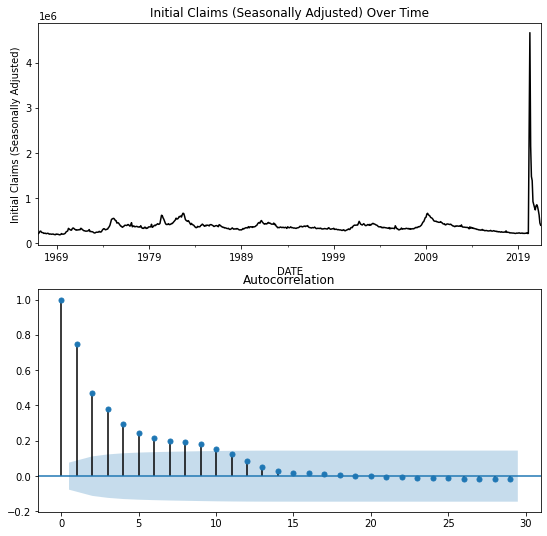

ADF TEST:DXY Close
ADF Statistic: -5.762013
p-value: 0.000001


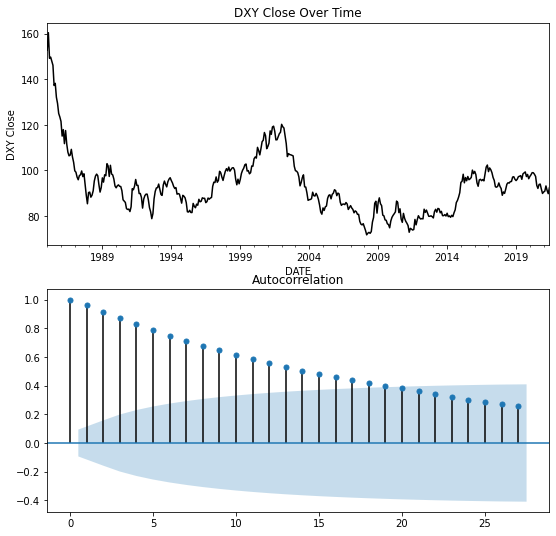

ADF TEST:Vix High
ADF Statistic: -4.798326
p-value: 0.000055


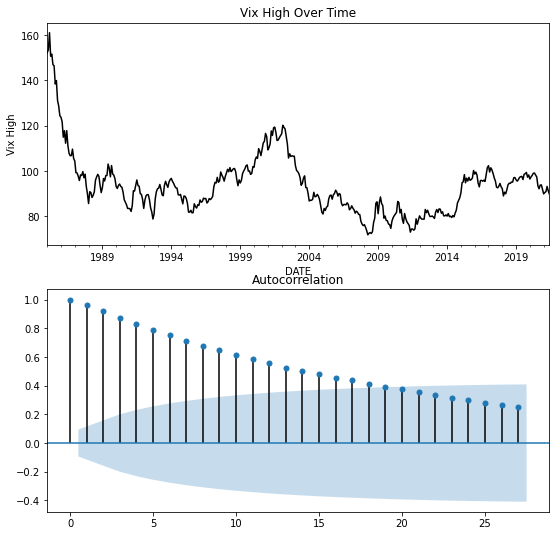

ADF TEST:Vix Low
ADF Statistic: -5.895472
p-value: 0.000000


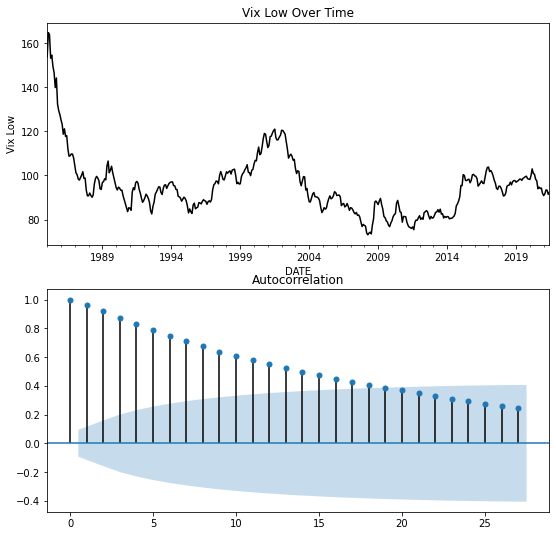

ADF TEST:Year
ADF Statistic: -0.109999
p-value: 0.948433
This Series is not stable
ADF TEST:PMI
ADF Statistic: -7.169164
p-value: 0.000000


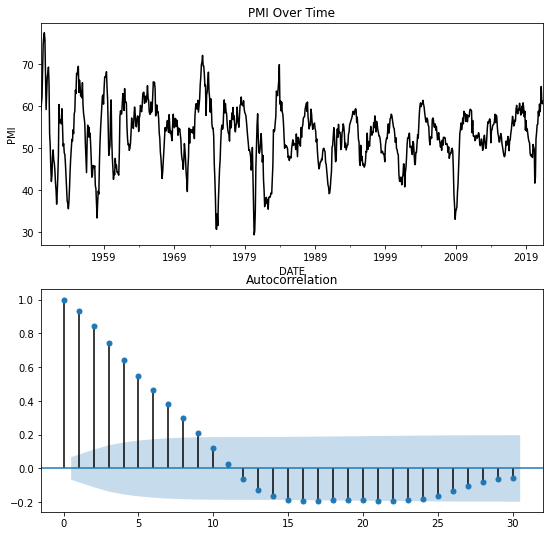

ADF TEST:TwoTenMonthlyVariance
ADF Statistic: -5.861827
p-value: 0.000000


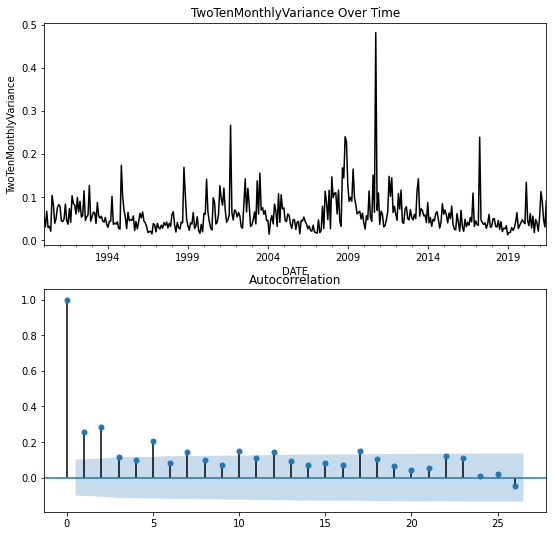

ADF TEST:CpiAnnualizedPct
ADF Statistic: -3.394541
p-value: 0.011146


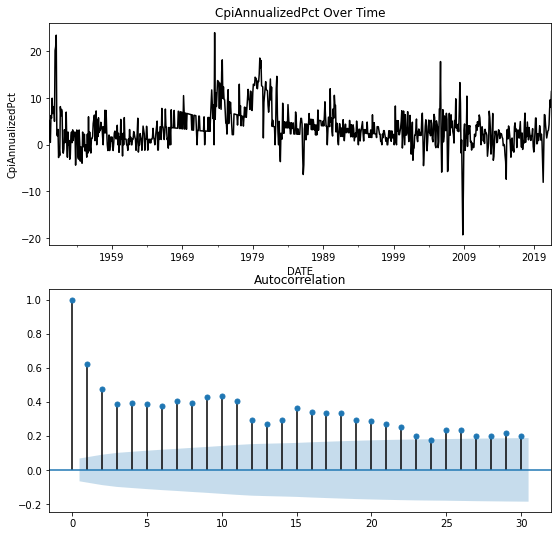

ADF TEST:GdpAnnualizedPct
ADF Statistic: -3.505054
p-value: 0.007858


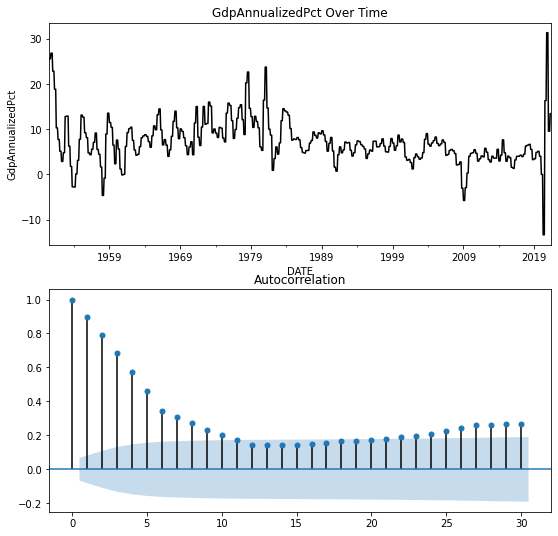

ADF TEST:BopPct
ADF Statistic: -20.627161
p-value: 0.000000


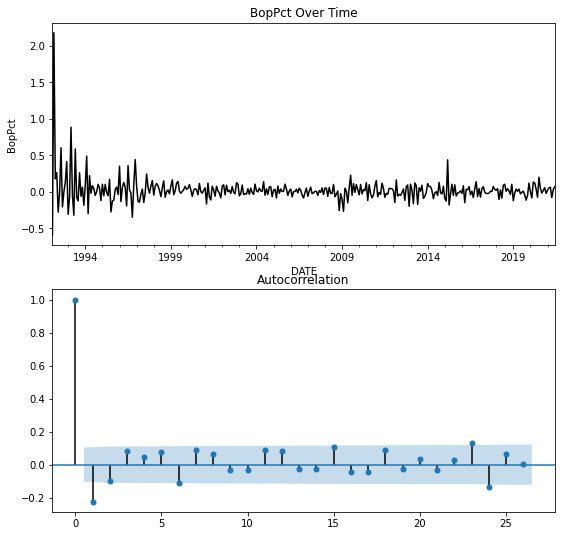

ADF TEST:InventoriesPct
ADF Statistic: -4.955661
p-value: 0.000027


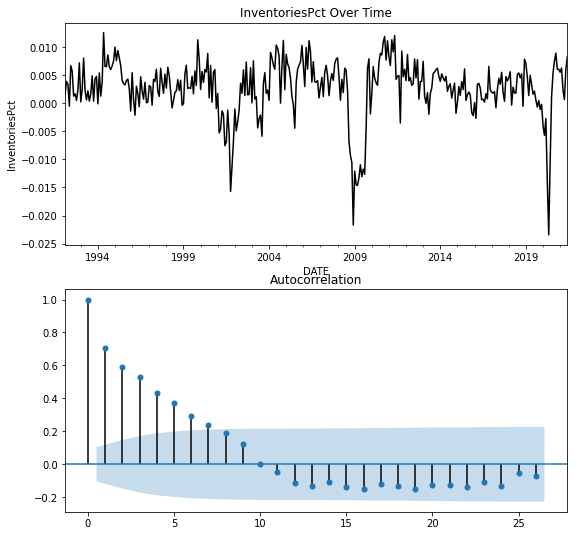

ADF TEST:WtiPct
ADF Statistic: -2.451469
p-value: 0.127733
This Series is not stable


In [ ]:
for column in list(dfmain.columns):
  if column == 'Month':
    pass
  else:
    #looping through all the columns in the df
    ADFtest(dfmain, column)

# WTI is not stationary remove
dfmain.drop(columns='WtiPct', inplace=True)

Running each series through the ARIMA Modeling function. Each Series is tested with different levels of differencing, moving average period, and autocorrelation period to identify the best fitting model.

Series:  Initial Claims (Seasonally Adjusted)
   AR  MA           AIC
8   3   2  13733.399067
RSME: 858540.6100229364


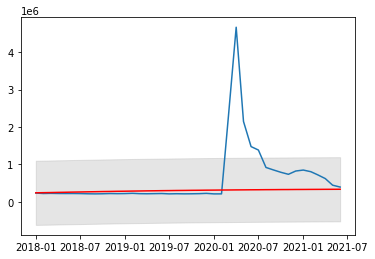

------------------------------------------------------
   AR  MA          AIC
2   2   2  13715.58645
RSME: 891935.22772104


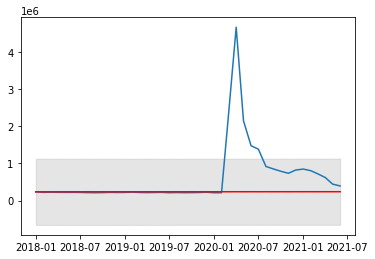

------------------------------------------------------
Series:  DXY Close
   AR  MA         AIC
1   1   2  1841.57258
RSME: 3.2737280119246965


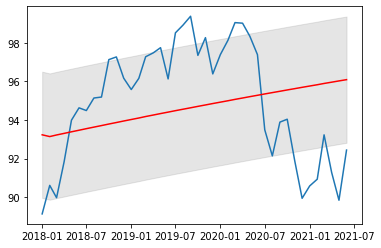

------------------------------------------------------
   AR  MA          AIC
0   2   1  1831.309863
RSME: 6.157926710703845


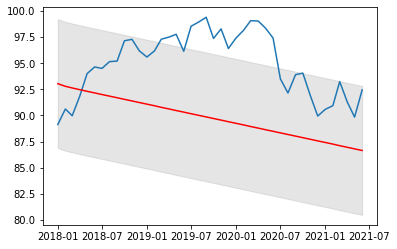

------------------------------------------------------
    AR  MA          AIC
12   3   4  1828.338706
RSME: 8.14770927822691


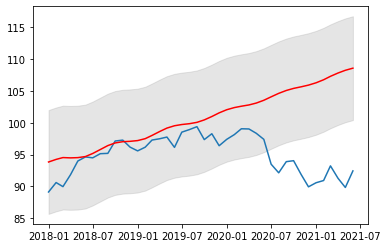

------------------------------------------------------
Series:  Vix High
   AR  MA          AIC
1   1   2  1842.574025
RSME: 3.4615024779891095


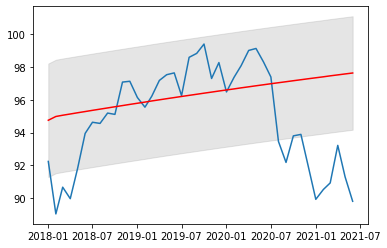

------------------------------------------------------
   AR  MA          AIC
1   2   1  1832.943936
RSME: 4.6286225184727074


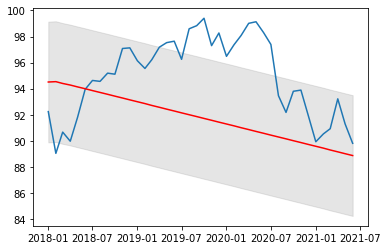

------------------------------------------------------
    AR  MA          AIC
10   2   5  1829.667763
RSME: 8.945001566023693


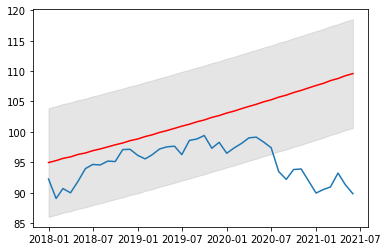

------------------------------------------------------
Series:  Vix Low
   AR  MA          AIC
3   1   4  1765.779214
RSME: 3.3583112222189198


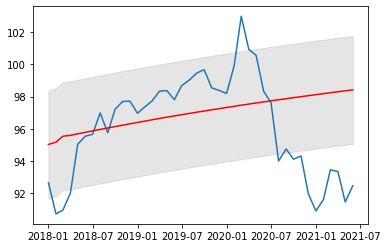

------------------------------------------------------
   AR  MA          AIC
2   2   2  1756.550086
RSME: 5.455637089805157


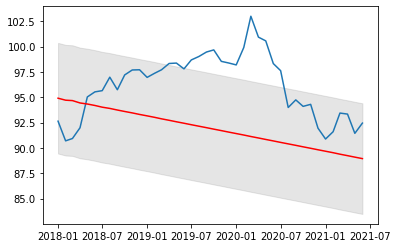

------------------------------------------------------
   AR  MA          AIC
7   2   3  1756.485566
RSME: 6.968802787203539


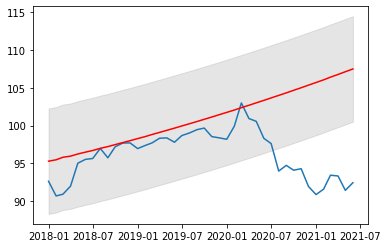

------------------------------------------------------
Series:  PMI
   AR  MA          AIC
2   1   3  3767.497624
RSME: 5.1267661963839055


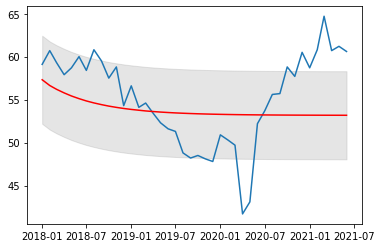

------------------------------------------------------
   AR  MA          AIC
2   1   4  3766.868583
RSME: 5.580588158162113


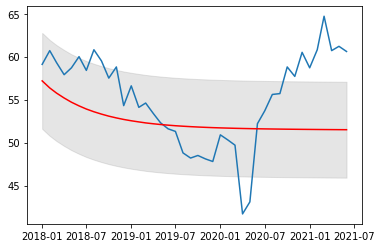

------------------------------------------------------
    AR  MA          AIC
16   3   5  3778.593061
RSME: 5.881578212259536


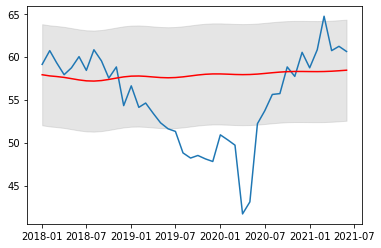

------------------------------------------------------
Series:  TwoTenMonthlyVariance
   AR  MA          AIC
5   3   2 -1175.838065
RSME: 0.031137409950835


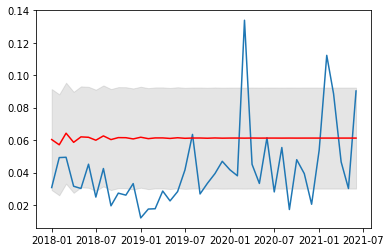

------------------------------------------------------
   AR  MA         AIC
8   2   4 -1168.83095
RSME: 0.027158560240501128


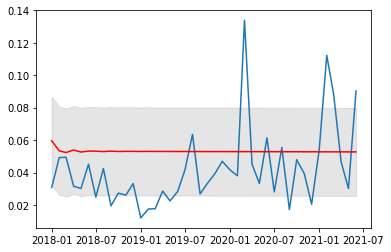

------------------------------------------------------
   AR  MA          AIC
0   1   5 -1143.785832
RSME: 0.02674432446078528


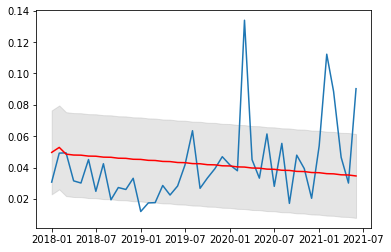

------------------------------------------------------
Series:  CpiAnnualizedPct
    AR  MA          AIC
16   3   5  4107.578187
RSME: 3.2998828278490775


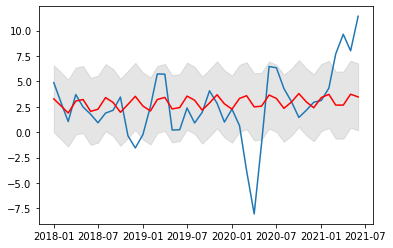

------------------------------------------------------
    AR  MA          AIC
10   2   5  4107.679546
RSME: 3.393144826338672


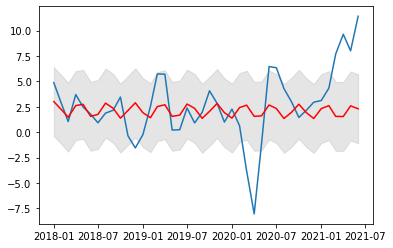

------------------------------------------------------
Series:  GdpAnnualizedPct
    AR  MA         AIC
16   3   5  2771.42172
RSME: 9.407017428220943


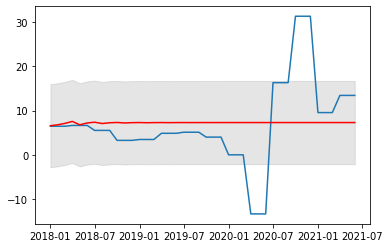

------------------------------------------------------
    AR  MA          AIC
17   3   6  2757.381613
RSME: 9.944684894836135


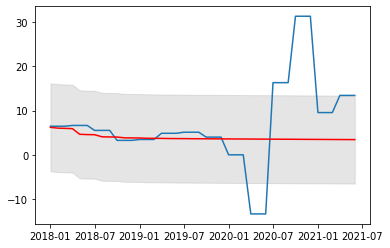

------------------------------------------------------
    AR  MA          AIC
13   3   4  2867.045656
RSME: 9.276912674250209


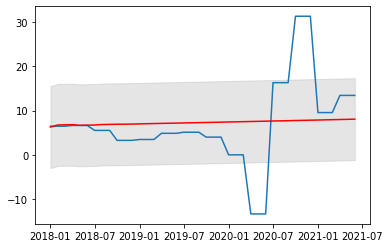

------------------------------------------------------
Series:  BopPct
   AR  MA         AIC
3   1   4 -207.221355
RSME: 0.07292133038640318


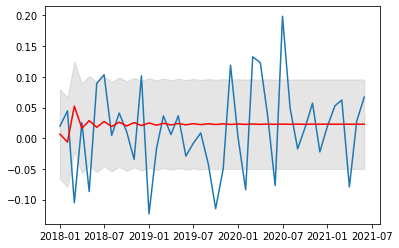

------------------------------------------------------
   AR  MA         AIC
0   1   3 -218.104466
RSME: 0.07959185360809812


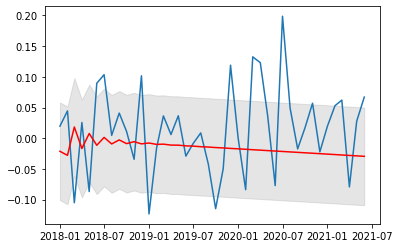

------------------------------------------------------
   AR  MA         AIC
1   1   4 -206.695176
RSME: 0.07829943187426087


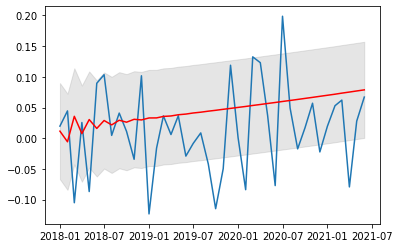

------------------------------------------------------
Series:  InventoriesPct
    AR  MA          AIC
10   3   3 -2653.874587
RSME: 0.006168561066923779


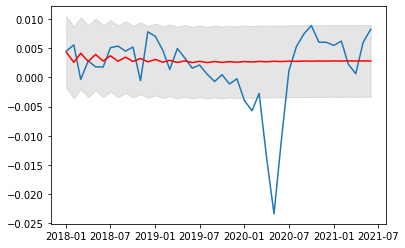

------------------------------------------------------
    AR  MA          AIC
12   3   3 -2634.497495
RSME: 0.006155102521342884


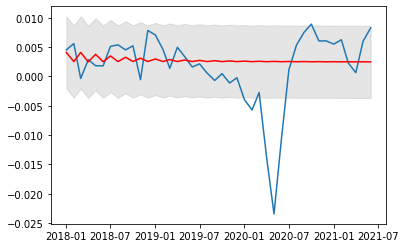

------------------------------------------------------
   AR  MA         AIC
0   1   3 -2607.18206
RSME: 0.006452361377841797


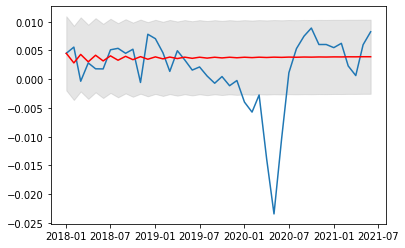

------------------------------------------------------


In [ ]:
for column  in list(dfmain.columns):
  if (column == 'Year') | (column == 'Month') | (column =='WtiPct'):
    pass
  else:
    subsetdf = dfmain[column]
    print("Series: ", column)
    # looping through various differencings
    ARIMA_modeling_and_forecast(subsetdf, column, 0)
    ARIMA_modeling_and_forecast(subsetdf, column, 1)
    if (column == 'CpiAnnualizedPct') |(column =='Initial Claims (Seasonally Adjusted)'):
      pass
    else:
      ARIMA_modeling_and_forecast(subsetdf, column, 2)



# Correlation Analysis of Econ Data vs. Return Data
Functions to Assign the quads for the GDP/CPI model and the PMI/CPI model. The PMI/CPI model was used in the final analysis due to the forward looking nature of the PMI vs GDP.

Function to calculate forward 6 month and 3 month periods from a monthly return series. This calculation is the basis of the return reccomendations later.

In [ ]:
# GDP vs CPI
def assign_quads(row):
  if row['GdpAnnualizedPct'] > 0 and row['CpiAnnualizedPct'] <= 0:
    return 'Q1'
  elif row['GdpAnnualizedPct'] > 0 and row['CpiAnnualizedPct'] > 0:
    return 'Q2'
  elif row['GdpAnnualizedPct'] <= 0 and row['CpiAnnualizedPct'] > 0:
    return 'Q3'
  else:
    return 'Q4'

# PMI vs CPI
def assign_quads2(row):
  if row['PMI'] > 50 and row['CpiAnnualizedPct'] <= 0:
    return 'Q1'
  elif row['PMI'] > 50 and row['CpiAnnualizedPct'] > 0:
    return 'Q2'
  elif row['PMI'] <= 50 and row['CpiAnnualizedPct'] > 0:
    return 'Q3'
  else:
    return 'Q4'

In [ ]:
def forward_returns(df, column):
  # calculates 3 period and 6 period forward returns
  
  # need standard deviation for same periods

  # 3 month forward return
  indexer3 = pd.api.indexers.FixedForwardWindowIndexer(window_size=3)
  df[column+'forward3'] =df[column].rolling(window=indexer3).agg(lambda x: x.prod()-1)
  # 6 month forward return
  indexer6 = pd.api.indexers.FixedForwardWindowIndexer(window_size=6)

  df[column+'forward6'] =df[column].rolling(window=indexer6).agg(lambda x: x.prod()-1)
  return df

# Reading in S&P500 Return data and Quad Return Profile

In [ ]:
index_data = pd.read_excel("https://raw.githubusercontent.com/AlexNoonan-Syracuse/BigDataProject/main/Index%20Sectors.xlsx", skiprows=2)
index_data = index_data[0:611]
all_index = pd.melt(index_data, id_vars=["Period Ending"], 
                  var_name="Index", value_name="Value")

all_index.rename(columns={'Period Ending':'Date','Value':'Return'}, inplace=True)
all_index['Date'] = pd.to_datetime(all_index['Date'])
all_index['Month'] = all_index['Date'].dt.to_period("M")
all_index['Year'] = all_index['Date'].dt.to_period("Y")
all_index.set_index('Date', drop=True, inplace=True)
all_index['Pct'] = all_index['Return']/100

all_index['Pct'] = all_index['Pct']+1
all_index = forward_returns(all_index,'Pct')

all_index.tail(10)

,Index,Return,Month,Year,Pct,Pctforward3,Pctforward6
Date,,,,,,,
2020-08-31,Russell - 1000 Index,7.339704,2020-08,2020,1.073397,0.009228,0.166078
2020-09-30,Russell - 1000 Index,-3.654778,2020-09,2020,0.963452,0.050936,0.117827
2020-10-31,Russell - 1000 Index,-2.411476,2020-10,2020,0.975885,0.136917,0.204138
2020-11-30,Russell - 1000 Index,11.775713,2020-11,2020,1.117757,0.155416,0.300314
2020-12-31,Russell - 1000 Index,4.227565,2020-12,2020,1.042276,0.063648,0.168846
2021-01-31,Russell - 1000 Index,-0.823596,2021-01,2021,0.991764,0.059125,NaN
2021-02-28,Russell - 1000 Index,2.898054,2021-02,2021,1.028981,0.125407,NaN
2021-03-31,Russell - 1000 Index,3.784333,2021-03,2021,1.037843,0.098903,NaN
2021-04-30,Russell - 1000 Index,5.383057,2021-04,2021,1.053831,NaN,NaN


#Exploratory Analysis of Index Data

In [ ]:
DW_conservative_index = index_data[['Dow Jones - U.S. Conservative Index']]
US_RealEstate_index = index_data[['U.S. Select Real Estate Securities Index']]
DJ30_index = index_data[['Dow Jones 30']]
NASDAQ100_index = index_data[['NASDAQ - 100 Index']]
RUSSELL1000_index = index_data[['Russell - 1000 Index']]
SP500_index = index_data[['S&P - 500 Index']]



DW_conservative_index.columns = ['DW_Conservative_Index']
US_RealEstate_index.columns = ['US_RealEstate_Index']
DJ30_index.index.columns = ['Dow Jones 30']
NASDAQ100_index.columns = ['NASDAQ100_Index']
RUSSELL1000_index.columns = ['RUSSELL1000_Index']
SP500_index.columns = ['S&P - 500 Index']

Text(0.5, 1.0, 'Dow Jones - U.S. Conservative Index')

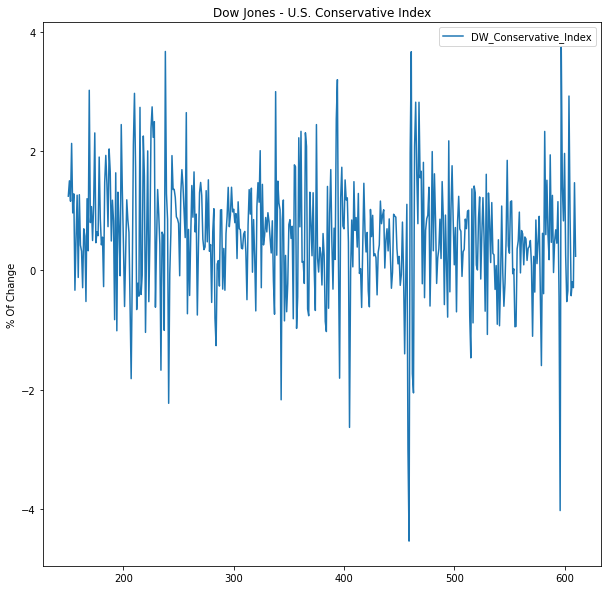

In [ ]:
DW_conservative_index["DW_Conservative_Index"].plot(figsize=(10,10))
plt.legend()
plt.ylabel("% Of Change")
plt.title("Dow Jones - U.S. Conservative Index")

Text(0.5, 1.0, 'U.S. Select Real Estate Securities Index')

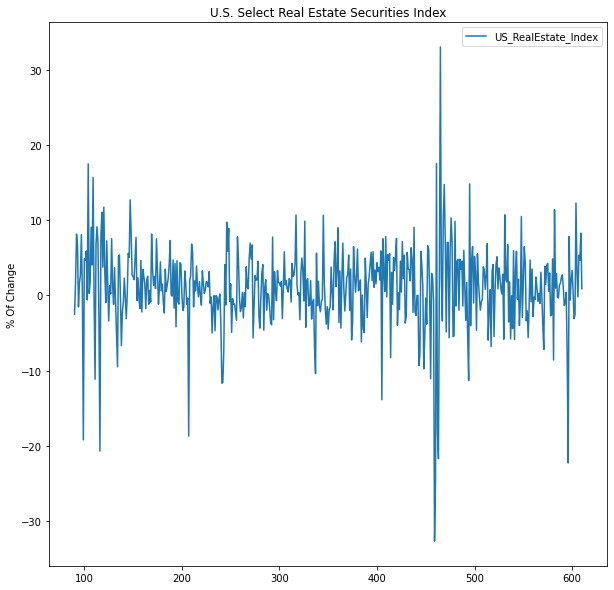

In [ ]:
US_RealEstate_index['US_RealEstate_Index'].plot(figsize=(10,10))
plt.legend()
plt.ylabel("% Of Change")
plt.title("U.S. Select Real Estate Securities Index")


Text(0.5, 1.0, 'DOW Jones 30')

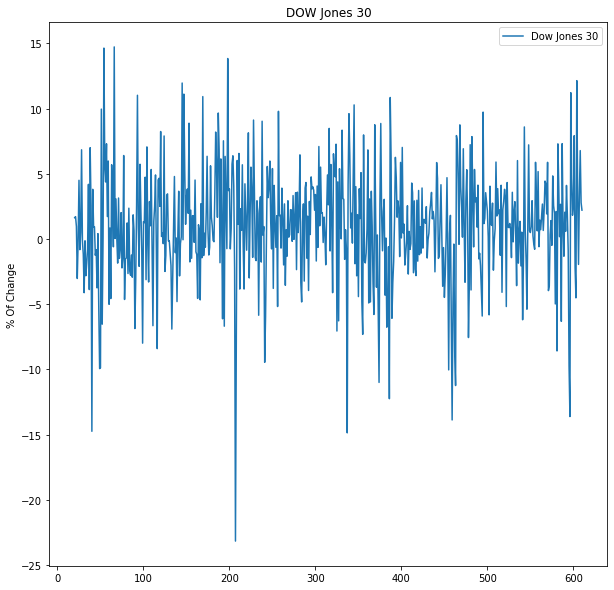

In [ ]:
DJ30_index['Dow Jones 30'].plot(figsize=(10,10))
plt.legend()
plt.ylabel("% Of Change")
plt.title("DOW Jones 30")

In [ ]:
DJI = pd.read_csv("https://raw.githubusercontent.com/AlexNoonan-Syracuse/BigDataProject/main//DJI.csv") #DOW JONES INDUSTRIAL AVERAGE
GSPC = pd.read_csv("https://raw.githubusercontent.com/AlexNoonan-Syracuse/BigDataProject/main/GSPC.csv") #S&P 500
IXIC = pd.read_csv("https://raw.githubusercontent.com/AlexNoonan-Syracuse/BigDataProject/main/DJI.csv") #NASDAQ COMPOSITE 
NYA = pd.read_csv("https://raw.githubusercontent.com/AlexNoonan-Syracuse/BigDataProject/main/NYA.csv") #NYSE COMPOSITE 
RUT = pd.read_csv("https://raw.githubusercontent.com/AlexNoonan-Syracuse/BigDataProject/main//RUT.csv") #RUSSELL 2000 
XAX = pd.read_csv("https://raw.githubusercontent.com/AlexNoonan-Syracuse/BigDataProject/main//XAX.csv") #NYSE AMEX COMPOSITE 

column_names = ['date', 'open', 'high', 'low', 'close','volume', 'adjusted']

DJI.columns = column_names
GSPC.columns = column_names
IXIC.columns = column_names
NYA.columns = column_names
RUT.columns = column_names
XAX.columns = column_names

DJI['date'] = pd.to_datetime(DJI['date'], infer_datetime_format=True)
GSPC['date'] = pd.to_datetime(GSPC['date'], infer_datetime_format=True)
IXIC['date'] = pd.to_datetime(IXIC['date'], infer_datetime_format=True)
NYA['date'] = pd.to_datetime(NYA['date'], infer_datetime_format=True)
RUT['date'] = pd.to_datetime(RUT['date'], infer_datetime_format=True)
XAX['date'] = pd.to_datetime(XAX['date'], infer_datetime_format=True)

DJI = DJI.set_index('date')
GSPC = GSPC.set_index('date')
IXIC = IXIC.set_index('date')
NYA = NYA.set_index('date')
RUT = RUT.set_index('date')
XAX = XAX.set_index('date')


figsize=(10,10)

Text(0.5, 1.0, 'DOW JONES INDUSTRIAL AVERAGE')

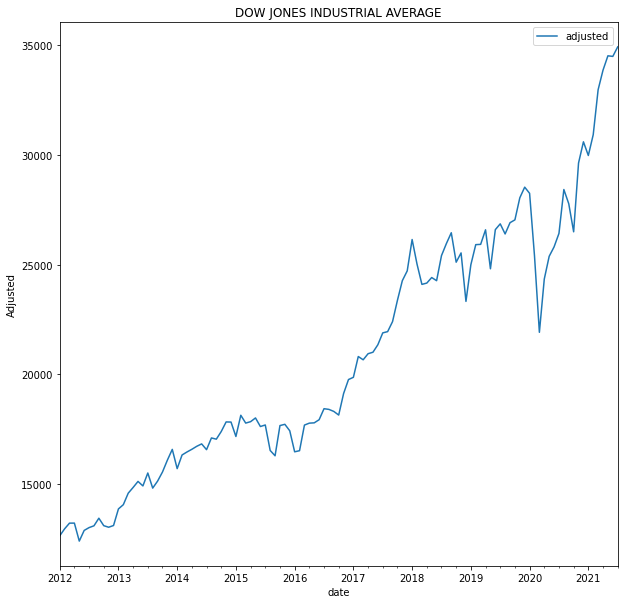

In [ ]:
DJI['adjusted'].plot(figsize=(10,10))
plt.legend()
plt.ylabel("Adjusted")
plt.title("DOW JONES INDUSTRIAL AVERAGE")

Text(0.5, 1.0, 'NASDAQ COMPOSITE')

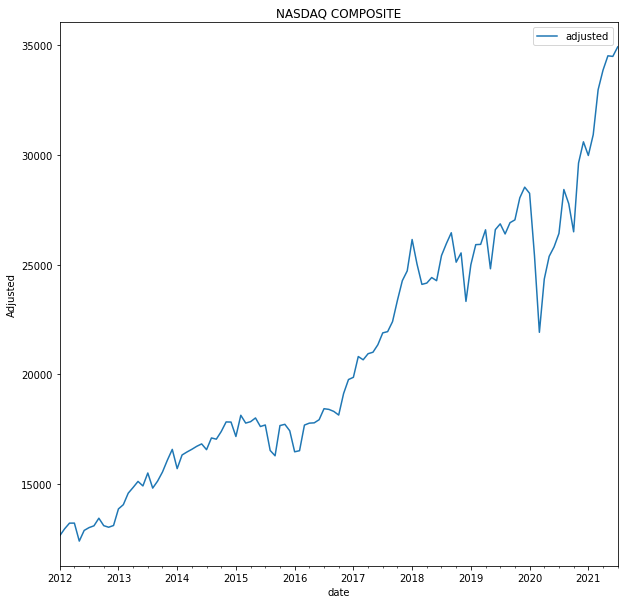

In [ ]:
IXIC['adjusted'].plot(figsize=(10,10))
plt.legend()
plt.ylabel("Adjusted")
plt.title("NASDAQ COMPOSITE")

Text(0.5, 1.0, 'RUSSELL 2000')

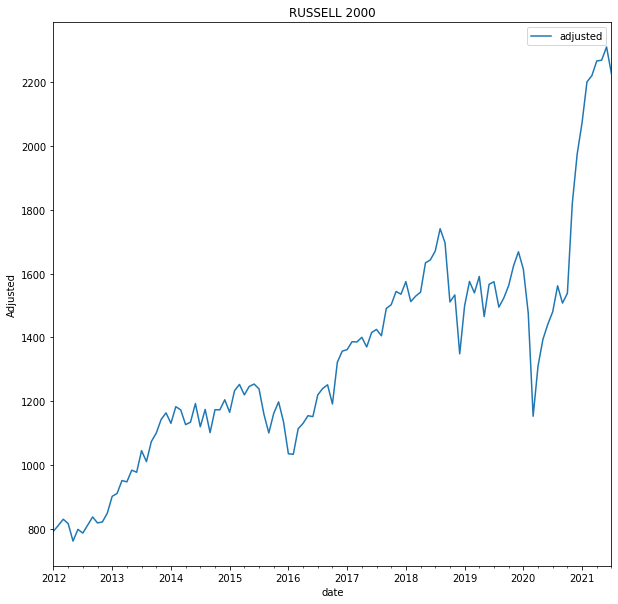

In [ ]:
RUT['adjusted'].plot(figsize=(10,10))
plt.legend()
plt.ylabel("Adjusted")
plt.title("RUSSELL 2000")

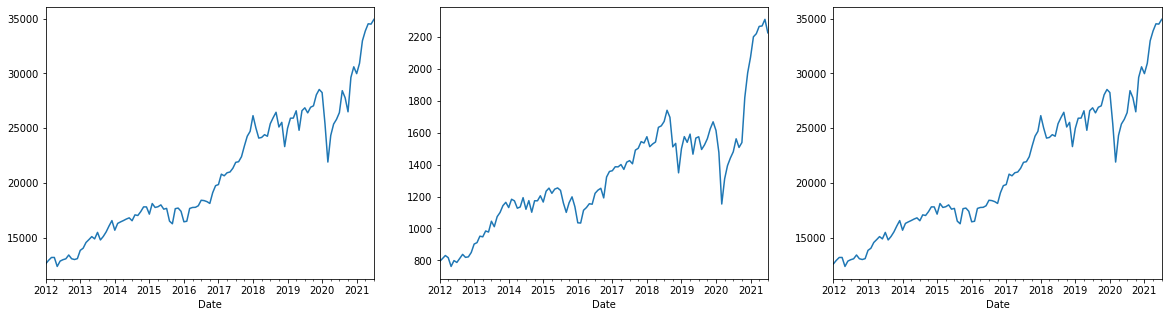

In [ ]:
plt.figure(figsize=(20,5))

ax1 = plt.subplot(131)
DJI['adjusted'].plot(y='Adjusted',xlabel="Date", ax=ax1)

ax2 = plt.subplot(132)
RUT['adjusted'].plot(y='Adjusted',xlabel="Date", ax=ax2)

ax3 = plt.subplot(133)
IXIC['adjusted'].plot(y='Adjusted',xlabel="Date", ax=ax3)

plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f58a2c994d0>,
      dtype=object)

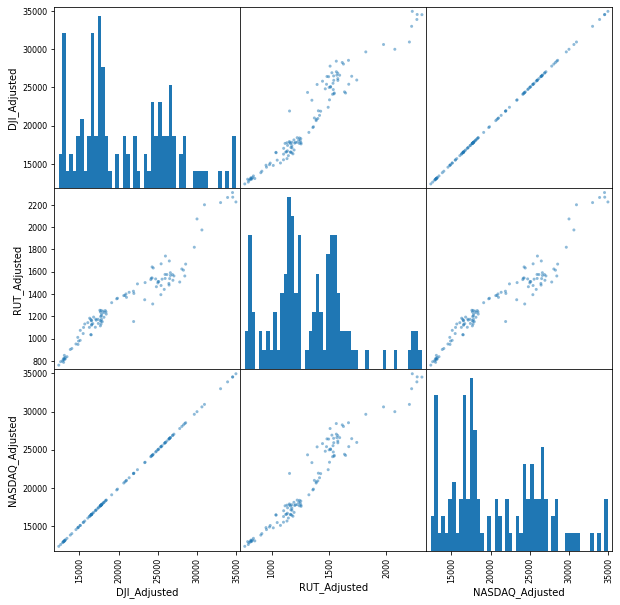

In [ ]:
data = pd.concat([DJI['adjusted'],RUT['adjusted'],IXIC['adjusted']],axis = 1)
data.columns = ['DJI_Adjusted','RUT_Adjusted','NASDAQ_Adjusted']
pd.plotting.scatter_matrix(data, figsize = (10,10), hist_kwds= {'bins':50})

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5897b32f50>,
      dtype=object)

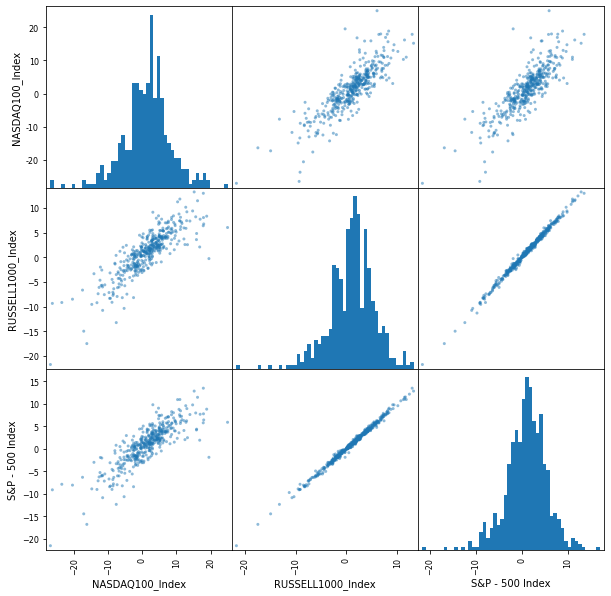

In [ ]:
data = pd.concat([NASDAQ100_index['NASDAQ100_Index'],RUSSELL1000_index['RUSSELL1000_Index'],SP500_index['S&P - 500 Index']],axis = 1)
data.columns = ['NASDAQ100_Index','RUSSELL1000_Index','S&P - 500 Index']
pd.plotting.scatter_matrix(data, figsize = (10,10), hist_kwds= {'bins':50})


# Macro Model 1 Annualized GDP vs CPI (Didn't use in Final Analysis)


No handles with labels found to put in legend.


            CpiAnnualizedPct  GdpAnnualizedPct Quads
DATE                                                
1950-12-01         20.195421         26.187881    Q2
1951-01-01         21.001347         25.730146    Q2
1951-02-01         23.479102         25.272412    Q2
1951-03-01          2.347771         24.814677    Q2
1951-04-01          1.870562         23.484415    Q2
1951-05-01          3.289313         22.154153    Q2
1951-06-01         -2.735391         20.823891    Q1
1951-07-01         -0.921652         18.734559    Q1
1951-08-01         -2.291287         16.645228    Q1
1951-09-01          8.180198         14.555897    Q2


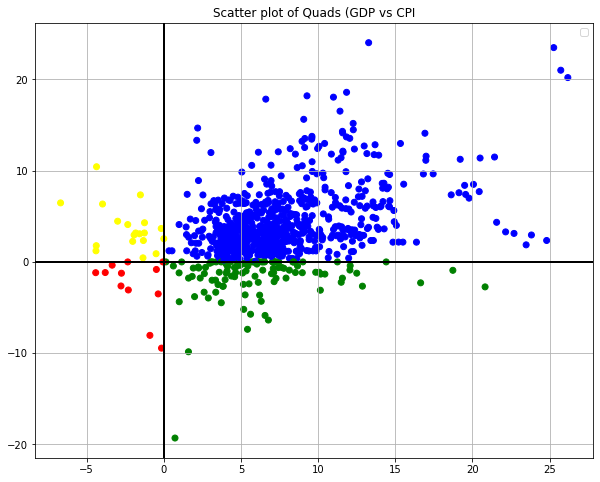

In [ ]:
#Source for quads for economics 
#https://app.hedgeye.com/edge/university


cpiGdp = dfmain[['CpiAnnualizedPct', 'GdpAnnualizedPct']]
cpiGdp['GdpAnnualizedPct'] = cpiGdp['GdpAnnualizedPct'].rolling(window=6).mean()
cpiGdp.dropna(inplace=True)
cpiGdp['Quads'] = cpiGdp.apply(lambda row: assign_quads(row) ,axis=1 )
print(cpiGdp.head(10))
colors = {'Q1':'green', 'Q2':'blue', 'Q3':'yellow', 'Q4':'red'}

fig, (ax) = plt.subplots(1, figsize=(10,8))
ax.set_title('Scatter plot of Quads (GDP vs CPI')
ax.scatter(cpiGdp['GdpAnnualizedPct'], cpiGdp['CpiAnnualizedPct'],c=cpiGdp['Quads'].map(colors) )
ax.grid()
plt.axvline(x=0, linewidth=2, color='k')
plt.axhline(y=0, linewidth=2, color='k')
plt.legend()
plt.show()

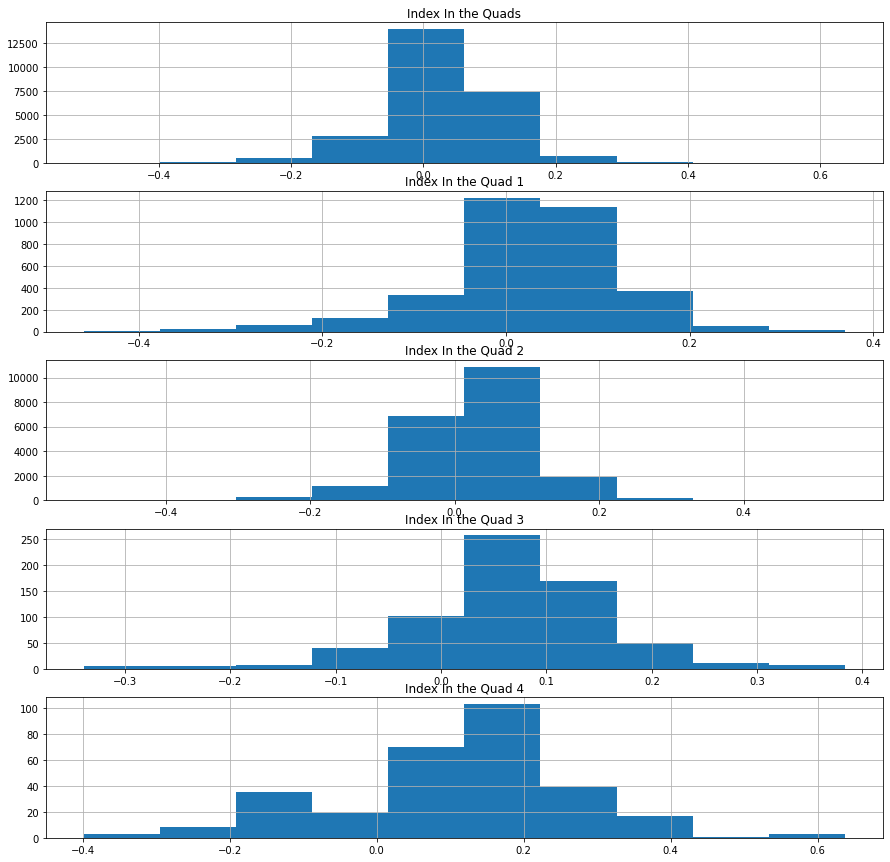

Pctforward3           Pctforward6          
             mean       std        mean       std
Quads                                            
Q1       0.026547  0.096528    0.047230  0.124828
Q2       0.026819  0.083123    0.054242  0.123611
Q3       0.069246  0.094054    0.168839  0.125614
Q4       0.113233  0.163142    0.215727  0.175522

In [ ]:
# Model 1 analysis of forward returns based on quads


cpiGdp['Month'] = cpiGdp.index.to_period("M")
IndexPlots = pd.merge(cpiGdp, all_index,how='inner', left_on='Month', right_on='Month')

IndexPlotsQ1 = IndexPlots[IndexPlots['Quads']=='Q1']
IndexPlotsQ2 = IndexPlots[IndexPlots['Quads']=='Q2']
IndexPlotsQ3 = IndexPlots[IndexPlots['Quads']=='Q3']
IndexPlotsQ4 = IndexPlots[IndexPlots['Quads']=='Q4']
fig, (axs) = plt.subplots(5, figsize=(15,15))
axs[0].set_title('Index In the Quads')
axs[0].hist(IndexPlots['Pctforward3'])
axs[0].grid()
#axs[0].legend()
axs[1].set_title('Index In the Quad 1')
axs[1].hist(IndexPlotsQ1['Pctforward3'])
axs[1].grid()
#axs[1].legend()
axs[2].set_title('Index In the Quad 2')
axs[2].hist(IndexPlotsQ2['Pctforward3'])
axs[2].grid()
#axs[2].legend()
axs[3].set_title('Index In the Quad 3')
axs[3].hist(IndexPlotsQ3['Pctforward3'])
axs[3].grid()
#axs[3].legend()
axs[4].set_title('Index In the Quad 4')
axs[4].hist(IndexPlotsQ4['Pctforward3'])
axs[4].grid()
#axs[4].legend()
plt.show()

# pivot table of average forward returns per quads
IndexPivot = pd.pivot_table(IndexPlots, values=['Pctforward3', 'Pctforward6'], index=IndexPlots['Quads'],aggfunc={np.mean,np.std})
IndexPivot.head()

# Macro Model 2 PMI vs Annualized CPI



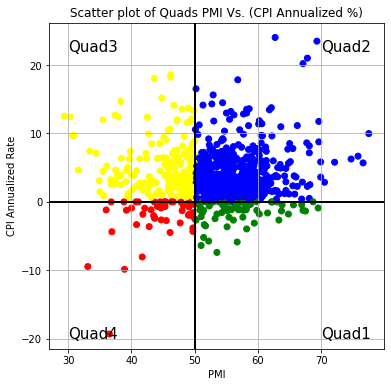

In [ ]:
# reading in pmi and CPI data
macrogrid2 = dfmain[['PMI','CpiAnnualizedPct']]
macrogrid2.dropna(inplace=True)


# assigning economic quad and 
macrogrid2['Quads'] = macrogrid2.apply(lambda row: assign_quads2(row), axis=1)

macrogrid2['Month'] = macrogrid2.index.to_period("M")
# plot of distribution of quads

colors = {'Q1':'green', 'Q2':'blue', 'Q3':'yellow', 'Q4':'red'}

fig, (ax) = plt.subplots(1, figsize=(6,6))
ax.set_title('Scatter plot of Quads PMI Vs. (CPI Annualized %)')
ax.scatter(macrogrid2['PMI'], macrogrid2['CpiAnnualizedPct'],c=macrogrid2['Quads'].map(colors))
plt.annotate("Quad1", (70,-20), fontsize=15)
plt.annotate("Quad2", (70,22),fontsize=15)
plt.annotate("Quad3", (30,22),fontsize=15)
plt.annotate("Quad4", (30,-20),fontsize=15)
ax.grid()
ax.set_xlabel("PMI")
ax.set_ylabel("CPI Annualized Rate")
plt.axvline(x=50, linewidth=2, color='k')
plt.axhline(y=0, linewidth=2, color='k')
plt.show()

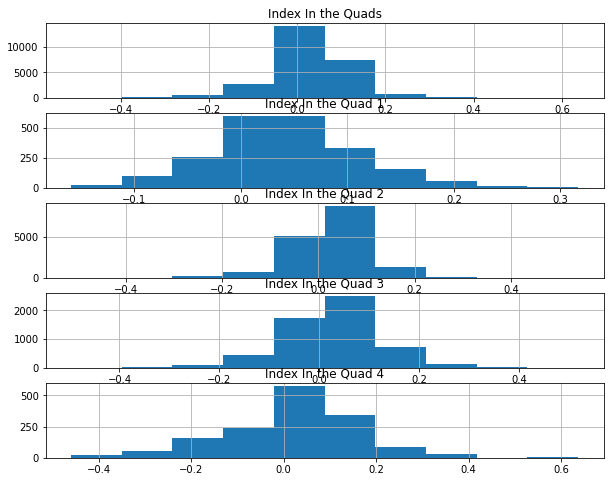

Pctforward3           Pctforward6          
             mean       std        mean       std
Quads                                            
Q1       0.041540  0.068959    0.053340  0.090190
Q2       0.029168  0.076186    0.061357  0.109403
Q3       0.025004  0.102321    0.047362  0.161217
Q4       0.022418  0.142573    0.071837  0.184578

In [ ]:
# need function taking in the "macrogrid2" Data frame and target security dataframe of monthly data

# month variable needs to be created on security dataframe if it isnt already so it can join to macrodataframe
# macrogrid2['Month'] = macrogrid2.index.to_period("M")
IndexPlots2 = pd.merge(macrogrid2, all_index, how='inner', on='Month')

# subset dataframes by plots 
IndexPlots2Q1 = IndexPlots2[IndexPlots2['Quads']=='Q1']
IndexPlots2Q2 = IndexPlots2[IndexPlots2['Quads']=='Q2']
IndexPlots2Q3 = IndexPlots2[IndexPlots2['Quads']=='Q3']
IndexPlots2Q4 = IndexPlots2[IndexPlots2['Quads']=='Q4']
# maybe plots can be improved to look nicer
fig, (axs) = plt.subplots(5, figsize=(10,8))
axs[0].set_title('Index In the Quads')
axs[0].hist(IndexPlots2['Pctforward3'])
axs[0].grid()
axs[1].set_title('Index In the Quad 1')
axs[1].hist(IndexPlots2Q1['Pctforward3'])
axs[1].grid()
axs[2].set_title('Index In the Quad 2')
axs[2].hist(IndexPlots2Q2['Pctforward3'])
axs[2].grid()

axs[3].set_title('Index In the Quad 3')
axs[3].hist(IndexPlots2Q3['Pctforward3'])
axs[3].grid()

axs[4].set_title('Index In the Quad 4')
axs[4].hist(IndexPlots2Q4['Pctforward3'])
axs[4].grid()
plt.show()
# need to add standard devaition to summary table and possible division of return/stdev

IndexPivot2 = pd.pivot_table(IndexPlots2,
                           values=['Pctforward3', 'Pctforward6'],
                           index=IndexPlots2['Quads'],aggfunc={np.mean,np.std})
IndexPivot2.head()

# Final Econ Forecast

Series:  CpiAnnualizedPct
    AR  MA          AIC
16   3   5  4107.578187
RSME: 3.2998828278490775


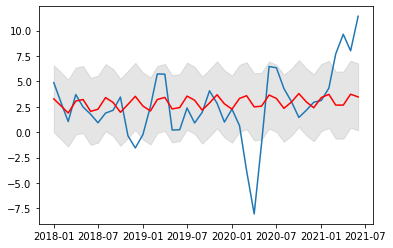

------------------------------------------------------
Series:  PMI
   AR  MA          AIC
2   1   3  3767.497624
RSME: 5.1267661963839055


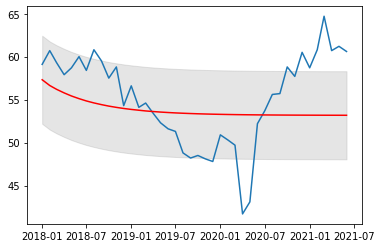

------------------------------------------------------
       Month  CpiAnnualizedPct        PMI QuadsForecast
0     August          3.281865  57.312348            Q2
1  September          2.560893  56.641162            Q2
2    October          1.885058  56.197732            Q2
3   November          3.064539  55.781301            Q2
4   December          3.216743  55.422108            Q2


In [ ]:
#CPI 6 Month Forecast
cpiDf = dfmain['CpiAnnualizedPct']
print("Series: ", 'CpiAnnualizedPct')
modeldf, CPIModel =ARIMA_modeling_and_forecast(cpiDf,'CpiAnnualizedPct',0)

# PMI 6 Month Forecast
pmiDf = dfmain['PMI']
print("Series: ", 'PMI')
modeldf, pmiModel =ARIMA_modeling_and_forecast(pmiDf,'PMI',0)

# 6 month forecast and final analysis dataframe
nextSixMonths = ['August', 'September', 'October', 'November', 'December', 'January']

cpiPredictions = CPIModel.forecast(steps=6)[0]

pmiPredicitions = pmiModel.forecast(steps=6)[0]

finalPredictionsdf = pd.DataFrame({'Month':nextSixMonths,'CpiAnnualizedPct': cpiPredictions, 'PMI':pmiPredicitions })
finalPredictionsdf['QuadsForecast'] = finalPredictionsdf.apply(lambda row: assign_quads2(row), axis=1)
print(finalPredictionsdf.head())


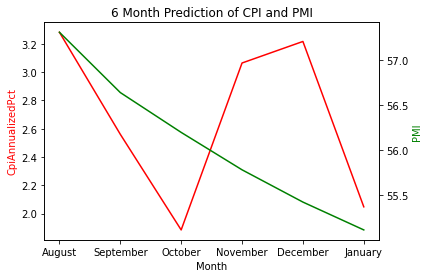

,Month,CpiAnnualizedPct,PMI,QuadsForecast
0,August,3.281865,57.312348,Q2
1,September,2.560893,56.641162,Q2
2,October,1.885058,56.197732,Q2
3,November,3.064539,55.781301,Q2
4,December,3.216743,55.422108,Q2
5,January,2.048265,55.112283,Q2


In [ ]:
# Forecast plot

fig, ax = plt.subplots()
plt.title("6 Month Prediction of CPI and PMI")
ax.plot(finalPredictionsdf['CpiAnnualizedPct'], label= 'CPI Forecast', color='Red')
ax.set_xlabel("Month")
ax.set_ylabel("CpiAnnualizedPct", color='Red')
ax2=ax.twinx()
ax2.plot(finalPredictionsdf['PMI'], label = 'PMI Forecast', color='Green')
ax2.set_ylabel("PMI", color='green')
ax.set_xticks(finalPredictionsdf.index)
ax.set_xticklabels(nextSixMonths)
plt.show()
finalPredictionsdf.head(7)

In [ ]:
nextSixMonths = ['August', 'September', 'October', 'November', 'December', 'January']

cpiPredictions = CPIModel.forecast(steps=6)[0]

pmiPredicitions = pmiModel.forecast(steps=6)[0]

finalPredictionsdf = pd.DataFrame({'Month':nextSixMonths,'CpiAnnualizedPct': cpiPredictions, 'PMI':pmiPredicitions })
finalPredictionsdf['QuadsForecast'] = finalPredictionsdf.apply(lambda row: assign_quads2(row), axis=1)
print(finalPredictionsdf.head())


       Month  CpiAnnualizedPct        PMI QuadsForecast
0     August          3.281865  57.312348            Q2
1  September          2.560893  56.641162            Q2
2    October          1.885058  56.197732            Q2
3   November          3.064539  55.781301            Q2
4   December          3.216743  55.422108            Q2


In [ ]:
return_quad = IndexPlots2[["Quads","Index","Pct","Pctforward3","Pctforward6"]]

return_quad_mean = return_quad.groupby(["Quads","Index"]).mean()
return_quad_mean = return_quad_mean.rename(columns={"Pct": "Mean Pct"})
return_quad_mean = return_quad_mean.rename(columns={"Pctforward3": "Mean Pctforward3"})
return_quad_mean = return_quad_mean.rename(columns={"Pctforward6": "Mean Pctforward6"})


return_quad_std = return_quad.groupby(["Quads","Index"]).std()
return_quad_std = return_quad_std.rename(columns={"Pct": "Std Pct"})
return_quad_std = return_quad_std.rename(columns={"Pctforward3": "Std Pctforward3"})
return_quad_std = return_quad_std.rename(columns={"Pctforward6": "Std Pctforward6"})


return_quad2 = pd.merge(return_quad_mean, return_quad_std, how='left', left_on=["Quads","Index"], right_on=["Quads","Index"])


In [ ]:
return_quad2

Mean Pct  ...  Std Pctforward6
Quads Index                                               ...                 
Q1    Dow Jones - Commodity Index               0.986791  ...         0.129139
      Dow Jones - EPAC Select Dividend Index    1.002013  ...         0.106166
      Dow Jones - Global Aggressive Index       1.014030  ...         0.091277
      Dow Jones - Global Conservative Index     1.003986  ...         0.024000
      Dow Jones - Global Moderate Index         1.008972  ...         0.052168
...                                                  ...  ...              ...
Q4    S&P - 500 Index (GICS Real Estate)        0.962967  ...         0.112189
      S&P - 500 Index (GICS Utilities)          1.008779  ...         0.139371
      U.S. Real Estate Index                    0.993313  ...         0.263278
      U.S. Select REIT Index                    0.990033  ...         0.276349
      U.S. Select Real Estate Securities Index  1.000436  ...         0.256919

[252 rows x 6 columns]

In [ ]:
return_quad2 = return_quad2.reset_index()
return_quad_std = return_quad_std.reset_index()
final_rec = pd.merge(finalPredictionsdf, return_quad2, how='left', left_on='QuadsForecast', right_on='Quads')
final_rec

,Month,CpiAnnualizedPct,PMI,QuadsForecast,Quads,Index,Mean Pct,Mean Pctforward3,Mean Pctforward6,Std Pct,Std Pctforward3,Std Pctforward6
0,August,3.281865,57.312348,Q2,Q2,Dow Jones - Commodity Index,1.014744,0.028621,0.058403,0.040278,0.076050,0.117859
1,August,3.281865,57.312348,Q2,Q2,Dow Jones - EPAC Select Dividend Index,1.010305,0.019285,0.047620,0.042734,0.079712,0.110568
2,August,3.281865,57.312348,Q2,Q2,Dow Jones - Global Aggressive Index,1.011648,0.032548,0.068238,0.038318,0.070006,0.100447
3,August,3.281865,57.312348,Q2,Q2,Dow Jones - Global Conservative Index,1.005602,0.016151,0.033425,0.009051,0.015858,0.022259
4,August,3.281865,57.312348,Q2,Q2,Dow Jones - Global Moderate Index,1.008411,0.023926,0.049901,0.020588,0.037328,0.051211
...,...,...,...,...,...,...,...,...,...,...,...,...
373,January,2.048265,55.112283,Q2,Q2,S&P - 500 Index (GICS Real Estate),1.009220,0.020780,0.057062,0.033674,0.080177,0.088759
374,January,2.048265,55.112283,Q2,Q2,S&P - 500 Index (GICS Utilities),1.009345,0.030521,0.064087,0.038969,0.069263,0.096779
375,January,2.048265,55.112283,Q2,Q2,U.S. Real Estate Index,1.011676,0.030250,0.064096,0.041864,0.071731,0.100652
376,January,2.048265,55.112283,Q2,Q2,U.S. Select REIT Index,1.012158,0.031459,0.067004,0.043886,0.076317,0.105555


In [ ]:
final_rec["3 month Mean / Std"] = final_rec["Mean Pctforward3"]/final_rec["Std Pctforward3"]
final_rec["6 month Mean / Std"] = final_rec["Mean Pctforward6"]/final_rec["Std Pctforward6"]

#Recommendation - top Index based on Quad Results

Top 3 Indexes - Based on 3 month Return over Std 

In [ ]:
#Top 3 index for 3 month forecast
top3_3mon = final_rec.sort_values(by='3 month Mean / Std', ascending=False)
top3_3mon = top3_3mon[["Month","Index","Mean Pctforward3","Std Pctforward3","3 month Mean / Std"]]

#Need to change the month to get different results
top3_3mon = top3_3mon[top3_3mon['Month'] == "September"] 
top3_3mon.head(3)

,Month,Index,Mean Pctforward3,Std Pctforward3,3 month Mean / Std
79,September,Dow Jones - U.S. Conservative Index,0.016614,0.016003,1.038200
66,September,Dow Jones - Global Conservative Index,0.016151,0.015858,1.018496
69,September,Dow Jones - Global Moderately Conservative Index,0.021041,0.027615,0.761945


Top 3 Indexes - Based on only 3 month return

In [ ]:
#Top 3 index for 3 month forecast
top3_3mon = final_rec.sort_values(by='Mean Pctforward3', ascending=False)
top3_3mon = top3_3mon[["Month","Index","Mean Pctforward3","Std Pctforward3","3 month Mean / Std"]]

#Need to change the month to get different results
top3_3mon = top3_3mon[top3_3mon['Month'] == "September"] 
top3_3mon.head(3)

,Month,Index,Mean Pctforward3,Std Pctforward3,3 month Mean / Std
86,September,NASDAQ - 100 Index,0.044072,0.104607,0.421307
119,September,S&P - 500 Index (GICS Information Technology),0.036974,0.099943,0.369946
94,September,NASDAQ - NASDAQ Over The Counter,0.036940,0.099933,0.369647


Top 3 Indexes - Based on 6 month Return over Std

In [ ]:
#Top 3 index for 6 month forecast
top3_6mon = final_rec.sort_values(by='6 month Mean / Std', ascending=False)
top3_6mon = top3_6mon[["Month","Index","Mean Pctforward6","Std Pctforward6","6 month Mean / Std"]]

#Need to change the month to get different results
top3_6mon = top3_6mon[top3_6mon['Month'] == "September"] 
top3_6mon.head(3)

,Month,Index,Mean Pctforward6,Std Pctforward6,6 month Mean / Std
79,September,Dow Jones - U.S. Conservative Index,0.034534,0.022074,1.564469
66,September,Dow Jones - Global Conservative Index,0.033425,0.022259,1.501672
69,September,Dow Jones - Global Moderately Conservative Index,0.043543,0.037364,1.165387


Top 3 Indexes - Based on only 6 month return

In [ ]:
#Top 3 index for 6 month forecast
top3_6mon = final_rec.sort_values(by='Mean Pctforward6', ascending=False)
top3_6mon = top3_6mon[["Month","Index","Mean Pctforward6","Std Pctforward6","6 month Mean / Std"]]

#Need to change the month to get different results
top3_6mon = top3_6mon[top3_6mon['Month'] == "September"] 
top3_6mon.head(3)

,Month,Index,Mean Pctforward6,Std Pctforward6,6 month Mean / Std
86,September,NASDAQ - 100 Index,0.094520,0.153236,0.616825
94,September,NASDAQ - NASDAQ Over The Counter,0.077108,0.145920,0.528429
119,September,S&P - 500 Index (GICS Information Technology),0.076056,0.145449,0.522902


#Security / Index Input
Input individual security or index to predict the return and then run through a reversion mean analysis

In [ ]:
!pip install yfinance

     |████████████████████████████████| 6.3 MB 5.5 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=f48f6c247f9aba8078c29b89e4962dc02e90d1bcadb0a3e9c834bffa994ffdc0
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
tickers = []
for _ in range(1):
    ticker = input("Please enter the ticker symbol: ")
    tickers.append(ticker)

lowercased = [ticker.lower() for ticker in tickers]
titlecased = [ticker.title() for ticker in lowercased]
ticker_details = [
    f"The model will run for {ticker}" for name in titlecased]

for ticker_detail in ticker_details:
    print(ticker_detail)

Please enter the ticker symbol: SBUX
The model will run for SBUX


In [ ]:
from pandas_datareader import data as pdr

import yfinance as yf
yf.pdr_override() # <== that's all it takes :-)

# download dataframe
ticker_data = pdr.get_data_yahoo(tickers)
ticker_data


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1992-06-26,0.328125,0.347656,0.320313,0.335938,0.277409,224358400
1992-06-29,0.339844,0.367188,0.332031,0.359375,0.296763,58732800
1992-06-30,0.367188,0.371094,0.343750,0.347656,0.287086,34777600
1992-07-01,0.351563,0.359375,0.339844,0.355469,0.293538,18316800
1992-07-02,0.359375,0.359375,0.347656,0.355469,0.293538,13996800
...,...,...,...,...,...,...
2021-09-13,119.889999,120.150002,118.559998,119.180000,119.180000,4381100
2021-09-14,119.720001,119.860001,118.360001,118.860001,118.860001,4722800
2021-09-15,116.959999,117.019997,113.120003,114.639999,114.639999,11556200


In [ ]:
ticker_daily_returns = ticker_data['Adj Close'].pct_change()
ticker_monthly_returns = ticker_data['Adj Close'].resample('M').ffill().pct_change()
ticker_monthly_returns2 = pd.DataFrame(ticker_monthly_returns)
ticker_monthly_returns2 = ticker_monthly_returns2.rename(columns={"Adj Close": "Monthly Return"})
ticker_monthly_returns2 = ticker_monthly_returns2.dropna()

In [ ]:
input_ticker = ticker_monthly_returns2
input_ticker = input_ticker.reset_index()
input_ticker['Date'] = pd.to_datetime(input_ticker['Date'])
input_ticker['Month'] = input_ticker['Date'].dt.to_period("M")
input_ticker['Year'] = input_ticker['Date'].dt.to_period("Y")
input_ticker.set_index('Date', drop=True, inplace=True)
input_ticker['Pct'] = input_ticker['Monthly Return']

input_ticker['Pct'] = input_ticker['Pct']+1
input_ticker = forward_returns(input_ticker,'Pct')

print(input_ticker.head(10))

            Monthly Return    Month  Year       Pct  Pctforward3  Pctforward6
Date                                                                         
1992-07-31        0.196631  1992-07  1992  1.196631     0.359551     0.662923
1992-08-31       -0.065728  1992-08  1992  0.934272     0.107982     0.446010
1992-09-30        0.216079  1992-09  1992  1.216079     0.517588     0.457286
1992-10-31       -0.024792  1992-10  1992  0.975208     0.223141     0.256199
1992-11-30        0.279661  1992-11  1992  1.279661     0.305084     0.313558
1992-12-31       -0.019868  1992-12  1992  0.980132    -0.039736     0.271523
1993-01-31        0.040541  1993-01  1993  1.040541     0.027027     0.324324
1993-02-28       -0.058443  1993-02  1993  0.941557     0.006493     0.233767
1993-03-31        0.048276  1993-03  1993  1.048276     0.324138     0.337932
1993-04-30        0.019737  1993-04  1993  1.019737     0.289474     0.440790


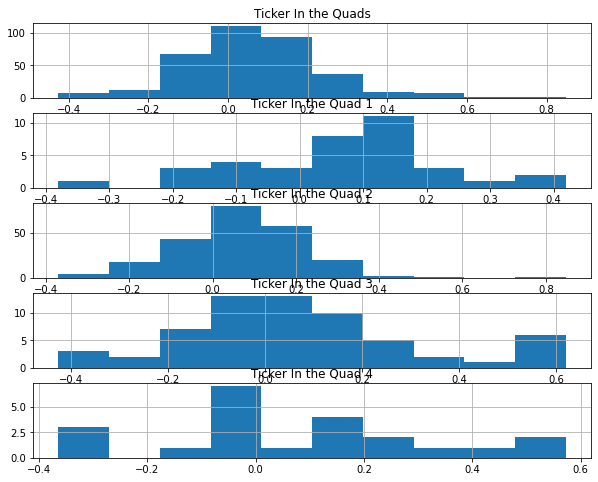

Pctforward3           Pctforward6          
             mean       std        mean       std
Quads                                            
Q1       0.068902  0.162733    0.094657  0.175000
Q2       0.065104  0.147447    0.128262  0.211431
Q3       0.067207  0.232446    0.131086  0.343507
Q4       0.072220  0.246761    0.231879  0.330555

In [ ]:
# month variable needs to be created on security dataframe if it isnt already so it can join to macrodataframe
# macrogrid2['Month'] = macrogrid2.index.to_period("M")
TickerPlots = pd.merge(macrogrid2, input_ticker, how='inner', on='Month')

# subset dataframes by plots 
TickerPlotsQ1 = TickerPlots[TickerPlots['Quads']=='Q1']
TickerPlotsQ2 = TickerPlots[TickerPlots['Quads']=='Q2']
TickerPlotsQ3 = TickerPlots[TickerPlots['Quads']=='Q3']
TickerPlotsQ4 = TickerPlots[TickerPlots['Quads']=='Q4']
# maybe plots can be improved to look nicer
fig, (axs) = plt.subplots(5, figsize=(10,8))
axs[0].set_title('Ticker In the Quads')
axs[0].hist(TickerPlots['Pctforward3'])
axs[0].grid()
axs[1].set_title('Ticker In the Quad 1')
axs[1].hist(TickerPlotsQ1['Pctforward3'])
axs[1].grid()
axs[2].set_title('Ticker In the Quad 2')
axs[2].hist(TickerPlotsQ2['Pctforward3'])
axs[2].grid()

axs[3].set_title('Ticker In the Quad 3')
axs[3].hist(TickerPlotsQ3['Pctforward3'])
axs[3].grid()

axs[4].set_title('Ticker In the Quad 4')
axs[4].hist(TickerPlotsQ4['Pctforward3'])
axs[4].grid()
plt.show()
# need to add standard devaition to summary table and possible division of return/stdev

TickerPivot = pd.pivot_table(TickerPlots,
                           values=['Pctforward3', 'Pctforward6'],
                           index=TickerPlots['Quads'],aggfunc={np.mean,np.std})
TickerPivot.head()

In [ ]:
ticker_quad = TickerPlots[["Quads","Pct","Pctforward3","Pctforward6"]]

ticker_quad_mean = ticker_quad.groupby(["Quads"]).mean()
ticker_quad_mean = ticker_quad_mean.rename(columns={"Pct": "Mean Pct"})
ticker_quad_mean = ticker_quad_mean.rename(columns={"Pctforward3": "Mean Pctforward3"})
ticker_quad_mean = ticker_quad_mean.rename(columns={"Pctforward6": "Mean Pctforward6"})


ticker_quad_std = ticker_quad.groupby(["Quads",]).std()
ticker_quad_std = ticker_quad_std.rename(columns={"Pct": "Std Pct"})
ticker_quad_std = ticker_quad_std.rename(columns={"Pctforward3": "Std Pctforward3"})
ticker_quad_std = ticker_quad_std.rename(columns={"Pctforward6": "Std Pctforward6"})


ticker_quad2 = pd.merge(ticker_quad_mean, ticker_quad_std, how='left', left_on=["Quads"], right_on=["Quads"])

In [ ]:
ticker_quad2 = ticker_quad2.reset_index()
ticker_quad_std = ticker_quad_std.reset_index()
final_rec2 = pd.merge(finalPredictionsdf, ticker_quad2, how='left', left_on='QuadsForecast', right_on='Quads')
final_rec2["3 month Mean / Std"] = final_rec2["Mean Pctforward3"]/final_rec2["Std Pctforward3"]
final_rec2["6 month Mean / Std"] = final_rec2["Mean Pctforward6"]/final_rec2["Std Pctforward6"]
final_rec2

,Month,CpiAnnualizedPct,PMI,QuadsForecast,Quads,Mean Pct,Mean Pctforward3,Mean Pctforward6,Std Pct,Std Pctforward3,Std Pctforward6,3 month Mean / Std,6 month Mean / Std
0,August,3.281865,57.312348,Q2,Q2,1.020364,0.065104,0.128262,0.089564,0.147447,0.211431,0.441541,0.606635
1,September,2.560893,56.641162,Q2,Q2,1.020364,0.065104,0.128262,0.089564,0.147447,0.211431,0.441541,0.606635
2,October,1.885058,56.197732,Q2,Q2,1.020364,0.065104,0.128262,0.089564,0.147447,0.211431,0.441541,0.606635
3,November,3.064539,55.781301,Q2,Q2,1.020364,0.065104,0.128262,0.089564,0.147447,0.211431,0.441541,0.606635
4,December,3.216743,55.422108,Q2,Q2,1.020364,0.065104,0.128262,0.089564,0.147447,0.211431,0.441541,0.606635
5,January,2.048265,55.112283,Q2,Q2,1.020364,0.065104,0.128262,0.089564,0.147447,0.211431,0.441541,0.606635


In [ ]:
#Security or Index Predicted Return
final_rec2 = final_rec2[final_rec2['Month'] == "September"] 
final_rec2
return_result3 = final_rec2['Mean Pctforward3'].tolist()
return_result6 = final_rec2['Mean Pctforward6'].tolist()
print(return_result3)
print(return_result6)

[0.06510408083428282]
[0.12826173043954517]


#Back Test - Reverse Mean
Additional insight for individual stock or index
Source: https://medium.com/raposa-technologies/how-to-build-your-first-mean-reversion-trading-strategy-in-python-8c9d4813ee40

In [ ]:
def SMAMeanReversion(ticker, sma, threshold, shorts=False,
start_date='2000-01-01', end_date='2020-12-31'):
    yfObj = yf.Ticker(ticker)
    data = yfObj.history(start=start_date, end=end_date)
    data['SMA'] = data['Close'].rolling(sma).mean()
    data['extension'] = (data['Close'] - data['SMA']) / data['SMA']
    
    data['position'] = np.nan
    data['position'] = np.where(data['extension']<-threshold,
        1, data['position'])
    if shorts:
        data['position'] = np.where(
            data['extension']>threshold, -1, data['position'])
        
    data['position'] = np.where(np.abs(data['extension'])<0.01,
        0, data['position'])
    data['position'] = data['position'].ffill().fillna(0)
    
    # Calculate returns and statistics
    data['returns'] = data['Close'] / data['Close'].shift(1)
    data['log_returns'] = np.log(data['returns'])
    data['strat_returns'] = data['position'].shift(1) * data['returns']
    data['strat_log_returns'] = data['position'].shift(1) * data['log_returns']
    data['cum_returns'] = np.exp(data['log_returns'].cumsum())
    data['strat_cum_returns']  = np.exp(data['strat_log_returns'].cumsum())
    data['peak'] = data['cum_returns'].cummax()
    data['strat_peak'] = data['strat_cum_returns'].cummax()
    
    return data.dropna()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

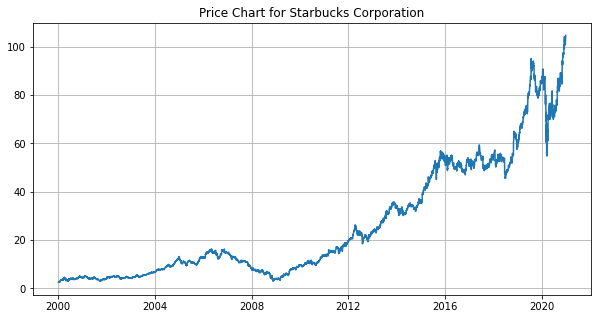

In [ ]:
yfObj = yf.Ticker(ticker)
data = yfObj.history(start="2000-01-01", end="2020-12-31")
name = yfObj.info['shortName']
plt.figure(figsize=(10, 5))
plt.plot(data['Close'])
plt.title(f'Price Chart for {name}')
plt.grid()
plt.show()

In [ ]:
def SMABacktest(ticker, short_term_sma, long_term_sma, 
    shorts=False, start_date='2000-01-01', end_date='2020-12-31'):
    yfObj = yf.Ticker(ticker)
    data = yfObj.history(start=start_date, end=end_date)
    
    data['SMA1'] = data['Close'].rolling(short_term_sma).mean()
    data['SMA2'] = data['Close'].rolling(long_term_sma).mean()
    if shorts:
        data['position'] = np.where(
            data['SMA1'] > data['SMA2'], 1, -1)
    else:
        data['position'] = np.where(
            data['SMA1'] > data['SMA2'], 1, 0)
    
    # Calculate returns
    data['returns'] = data['Close'] / data['Close'].shift(1)
    data['log_returns'] = np.log(data['returns'])
    data['strat_returns'] = data['position'].shift(1) * data['returns']
    data['strat_log_returns'] = data['position'].shift(1) * data['log_returns']
    data['cum_returns'] = np.exp(data['log_returns'].cumsum())
    data['strat_cum_returns'] = np.exp(data['strat_log_returns'].cumsum())
    data['peak'] = data['cum_returns'].cummax()
    data['strat_peak'] = data['strat_cum_returns'].cummax()
    
    return data

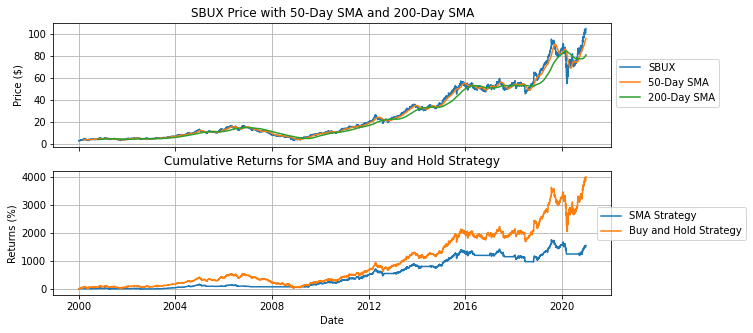

In [ ]:
short_term_sma = 50
long_term_sma = 200
data = SMABacktest(ticker, short_term_sma, long_term_sma)
fig, ax = plt.subplots(2, figsize=(10, 5), sharex=True)
ax[0].plot(data['Close'], label=ticker)
ax[0].plot(data['SMA1'], label=f"{short_term_sma}-Day SMA")
ax[0].plot(data['SMA2'], label=f"{long_term_sma}-Day SMA")
ax[0].set_ylabel('Price ($)')
ax[0].set_title(f'{ticker} Price with {short_term_sma}-Day SMA and {long_term_sma}-Day SMA')
ax[0].legend(bbox_to_anchor=[1, 0.75])
ax[0].grid()
ax[1].plot((data['strat_cum_returns'] - 1) * 100, label='SMA Strategy')
ax[1].plot((data['cum_returns'] - 1) * 100, label='Buy and Hold Strategy')
ax[1].set_ylabel('Returns (%)')
ax[1].set_xlabel('Date')
ax[1].set_title(f'Cumulative Returns for SMA and Buy and Hold Strategy')
ax[1].legend(bbox_to_anchor=[1.25, 0.75])
ax[1].grid()
plt.show()

In [ ]:
def getStratStats(data, risk_free_rate=0.02):
    sma_strat, buy_hold_strat = {}, {}
    
    # Total Returns
    sma_strat['tot_returns'] = np.exp(data['strat_log_returns'].sum()) - 1
    buy_hold_strat['tot_returns'] = np.exp(data['log_returns'].sum()) - 1
    
    # Mean Annual Returns
    sma_strat['annual_returns'] = np.exp(data['strat_log_returns'].mean() * 252) - 1
    buy_hold_strat['annual_returns'] = np.exp(data['log_returns'].mean() * 252) - 1
    
    # Annual Volatility
    sma_strat['annual_volatility'] = data['strat_log_returns'].std() * np.sqrt(252)
    buy_hold_strat['annual_volatility'] = data['log_returns'].std() * np.sqrt(252)
    
    # Sharpe Ratio
    sma_strat['sharpe_ratio'] = (sma_strat['annual_returns'] - risk_free_rate) / sma_strat['annual_volatility']
    buy_hold_strat['sharpe_ratio'] = (buy_hold_strat['annual_returns'] - risk_free_rate) / buy_hold_strat['annual_volatility']
    
    # Max Drawdown
    _strat_dd = data['strat_peak'] - data['strat_cum_returns']
    _buy_hold_dd = data['peak'] - data['cum_returns']
    sma_strat['max_drawdown'] = _strat_dd.max()
    buy_hold_strat['max_drawdown'] = _buy_hold_dd.max()
    
    # Max Drawdown Duration
    strat_dd = _strat_dd[_strat_dd==0]
    strat_dd_diff = strat_dd.index[1:] - strat_dd.index[:-1]
    strat_dd_days = strat_dd_diff.map(lambda x: x.days).values
    strat_dd_days = np.hstack([strat_dd_days, 
        (_strat_dd.index[-1] - strat_dd.index[-1]).days])
    
    buy_hold_dd = _buy_hold_dd[_buy_hold_dd==0]
    buy_hold_diff = buy_hold_dd.index[1:] - buy_hold_dd.index[:-1]
    buy_hold_days = buy_hold_diff.map(lambda x: x.days).values
    buy_hold_days = np.hstack([buy_hold_days,
        (_buy_hold_dd.index[-1] - buy_hold_dd.index[-1]).days])
    sma_strat['max_drawdown_duration'] = strat_dd_days.max()
    buy_hold_strat['max_drawdown_duration'] = buy_hold_days.max()
    
    stats_dict = {'strat_stats': sma_strat,'base_stats': buy_hold_strat}
    return stats_dict

In [ ]:
stats_dict = getStratStats(data, risk_free_rate=0.02)
pd.DataFrame(stats_dict).round(3)

,strat_stats,base_stats
tot_returns,15.527,40.137
annual_returns,0.143,0.194
annual_volatility,0.225,0.340
sharpe_ratio,0.547,0.513
max_drawdown,5.683,15.842
max_drawdown_duration,1724.000,1880.000


In [ ]:
spyObj = yf.Ticker('SPY')
spy_data = spyObj.history(start='2000-01-01', end='2020-12-31')
spy_ratio = spy_data['Close'][-1] / spy_data['Close'][0]
spy_ret = spy_ratio - 1
years = (spy_data.index[-1] - spy_data.index[0]).days / 365
spy_ann_ret = (spy_ratio) ** (1 / years) - 1
print(f'SPY Total Returns:\t{spy_ret*100:.2f}%' + 
      f'\nSPY Annual Returns:\t{spy_ann_ret*100:.2f}%')
      
print(f'SMA Total Returns:\t{stats_dict["strat_stats"]["tot_returns"]*100:.2f}%' +
      f'\nSMA Annual Returns:\t{stats_dict["strat_stats"]["annual_returns"]*100:.2f}%')

SPY Total Returns:	279.02%
SPY Annual Returns:	6.55%
SMA Total Returns:	1552.71%
SMA Annual Returns:	14.32%


In [ ]:

ticker = tickers[0]
SMA = 50
threshold = 0.1
shorts = False
data = SMAMeanReversion(ticker, SMA, threshold, shorts)
stats_dict = getStratStats(data)
df_stats = pd.DataFrame(stats_dict).round(3)
df_stats

,strat_stats,base_stats
tot_returns,1.204,28.188
annual_returns,0.039,0.176
annual_volatility,0.192,0.335
sharpe_ratio,0.098,0.466
max_drawdown,0.924,15.842
max_drawdown_duration,1432.000,1880.000


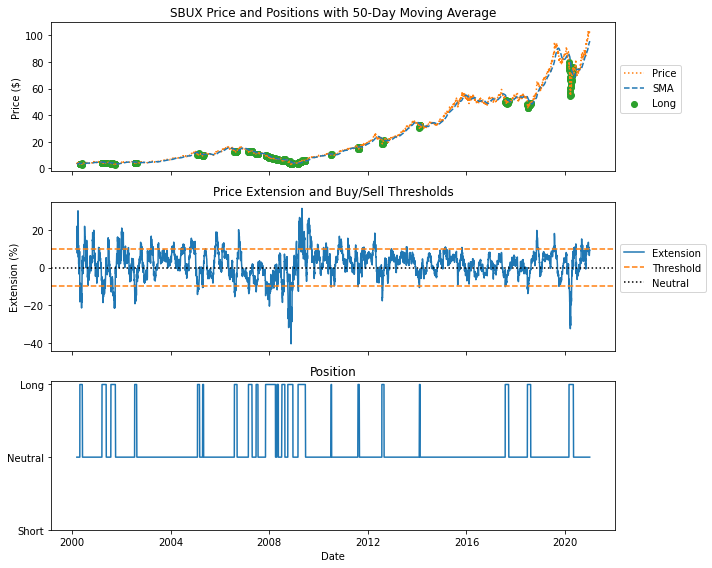

In [ ]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, ax = plt.subplots(3, figsize=(10, 8), sharex=True)
long = data.loc[data['position']==1]['Close']
ax[0].plot(data['Close'], label='Price', linestyle=':', color=colors[1])
ax[0].plot(data['SMA'], label='SMA', linestyle='--', color=colors[0])
ax[0].scatter(long.index, long, label='Long', c=colors[2])
ax[0].legend(bbox_to_anchor=[1, 0.75])
ax[0].set_ylabel('Price ($)')
ax[0].set_title(f'{ticker} Price and Positions with {SMA}-Day Moving Average')
ax[1].plot(data['extension']*100, label='Extension', color=colors[0])
ax[1].axhline(threshold*100, linestyle='--', color=colors[1])
ax[1].axhline(-threshold*100, label='Threshold', linestyle='--', color=colors[1])
ax[1].axhline(0, label='Neutral', linestyle=':', color='k')
ax[1].set_title('Price Extension and Buy/Sell Thresholds')
ax[1].set_ylabel(f'Extension (%)')
ax[1].legend(bbox_to_anchor=[1, 0.75])
ax[2].plot(data['position'])
ax[2].set_xlabel('Date')
ax[2].set_title('Position')
ax[2].set_yticks([-1, 0, 1])
ax[2].set_yticklabels(['Short', 'Neutral', 'Long'])
plt.tight_layout()
plt.show()

In [ ]:
def SMAMeanReversionSafety(ticker, sma, threshold, safety_threshold=0.25, shorts=False,
    start_date='2000-01-01', end_date='2020-12-31'):
    yfObj = yf.Ticker(ticker)
    data = yfObj.history(start=start_date, end=end_date)
    data['SMA'] = data['Close'].rolling(sma).mean()
    data['extension'] = (data['Close'] - data['SMA']) / data['SMA']
    
    data['position'] = np.nan
    data['position'] = np.where(
        (data['extension']<-threshold) & 
        (data['extension']>-safety_threshold), 
        1, data['position'])
    
    if shorts:
        data['position'] = np.where(
            (data['extension']>threshold) & 
            (data['extension']<safety_threshold),
            -1, data['position'])
        
    data['position'] = np.where(np.abs(data['extension'])<0.01,
        0, data['position'])
    data['position'] = data['position'].ffill().fillna(0)
    
    # Calculate returns and statistics
    data['returns'] = data['Close'] / data['Close'].shift(1)
    data['log_returns'] = np.log(data['returns'])
    data['strat_returns'] = data['position'].shift(1) * data['returns']
    data['strat_log_returns'] = data['position'].shift(1) * data['log_returns']
    data['cum_returns'] = np.exp(data['log_returns'].cumsum())
    data['strat_cum_returns'] = np.exp(data['strat_log_returns'].cumsum())
    data['peak'] = data['cum_returns'].cummax()
    data['strat_peak'] = data['strat_cum_returns'].cummax()
    
    return data.dropna()

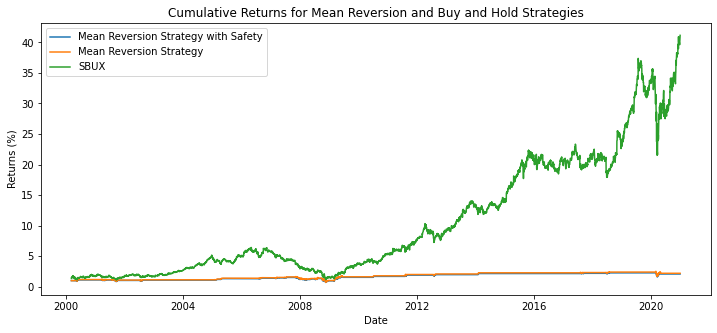

In [ ]:
ticker = tickers[0]
SMA = 50
threshold = 0.1
safety_threshold = 0.15
shorts = False
data = SMAMeanReversion(ticker, SMA, threshold, shorts)
data_safe = SMAMeanReversionSafety(ticker, SMA, threshold, safety_threshold, shorts)
safe_stats_dict = getStratStats(data_safe)
df_safe_stats = pd.DataFrame(safe_stats_dict).round(3)
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(data_safe['strat_cum_returns'], label='Mean Reversion Strategy with Safety')
ax.plot(data['strat_cum_returns'], label='Mean Reversion Strategy')
ax.plot(data_safe['cum_returns'], label=f'{ticker}')
ax.set_xlabel('Date')
ax.set_ylabel('Returns (%)')
ax.set_title('Cumulative Returns for Mean Reversion and Buy and Hold Strategies')
ax.legend()
plt.show()

In [ ]:
#Compare different stratgies 
df_safe_stats.columns = ['Mean Reversion with Safety', 'Buy and Hold']
df_stats.columns = ['Mean Reversion', 'x']
df_stats = pd.concat([df_stats.T, df_safe_stats.T])
df_stats.drop('x', axis=0, inplace=True)
df_stats

,tot_returns,annual_returns,annual_volatility,sharpe_ratio,max_drawdown,max_drawdown_duration
Mean Reversion,1.204,0.039,0.192,0.098,0.924,1432.0
Mean Reversion with Safety,1.087,0.036,0.192,0.084,0.874,1432.0
Buy and Hold,28.188,0.176,0.335,0.466,15.842,1880.0
